In [840]:
# ===========================
#  CARGA DE LIBRERÍAS
# ===========================

# NumPy y pandas para manejo de datos
import numpy as np
import pandas as pd

# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

# Estadística y regresión con Statsmodels
from statsmodels.api import OLS, add_constant

# Modelos lineales de Scikit-learn
from sklearn.linear_model import (
    LinearRegression,
    Ridge, Lasso, ElasticNet, LassoLars,
    RidgeCV, LassoCV, ElasticNetCV, LassoLarsCV
)

from group_lasso import GroupLasso

# Utilidades para entrenamiento y evaluación
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV
)
from sklearn.metrics import (
    mean_squared_error, r2_score, make_scorer
)

# Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler

# Pipeline y reducción de dimensionalidad
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Dataset de diabetes
from sklearn.datasets import load_diabetes

# Combinaciones útiles (por ejemplo, selección de variables)
from itertools import combinations


El **Diabetes Dataset** contiene información médica de pacientes y se utiliza para predecir la progresión de la enfermedad de la diabetes un año después de la recolección de los datos basales.

Tamaño del conjunto de datos:
- N° de muestras: 442 pacientes
- N° de predictores: 10 variables numéricas continuas

El conjunto de datos ha sido estandarizado (media 0, varianza 1). Los predictores son:
- Edad (age)
- Sexo (sex)
- Índice de masa corporal (BMI)
- Presión arterial media (bp)
- Seis medidas bioquímicas en sangre (s1 a s6)

In [841]:
# Cargar el dataset de Diabetes
diabetes = load_diabetes()

# Crear un DataFrame con los datos
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Agregar la columna de etiquetas (progresión de la diabetes)
df_diabetes['Progression'] = diabetes.target

# Mostrar las primeras filas
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [842]:
np.isnan(df_diabetes['Progression']).sum()

0

### División del DataSet Diabetes

El conjunto de datos, generalmente, se divide en tres muestras no superpuestas: 

- **Muestra de entrenamiento** utilizada para entrenar el modelo. 
- **Muestra de validación** utilizada para validar y ajustar el modelo. 
- **Muestra de prueba** utilizada para probar la capacidad predictiva del modelo en nuevos datos. 

In [843]:
# Preparar los datos
y = np.array(df_diabetes['Progression'])
X = df_diabetes.drop('Progression', axis=1)  # Mantén X como un DataFrame


#Dividir en entrenamiento, validación y prueba
pct_val = 0.20
pct_test = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=pct_test, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=pct_val/(1-pct_test), random_state=100)

### Elección del modelo óptimo

##### Cp de Mallows

In [844]:
# Modelo reducido: usaremos solo las primeras 4 variables como ejemplo
selected_features = ['age', 'sex', 'bmi', 'bp']

# Función para calcular Cp de Mallows
def Cp(X_train, y_train, selected_features):
    n = len(y_train)

    # Modelo completo para estimar sigma^2
    X_train_full = add_constant(X_train)
    model_full = OLS(y_train, X_train_full).fit()
    sigma2_hat = model_full.scale

    # Modelo reducido con las variables seleccionadas
    X_train_reduced = add_constant(X_train[selected_features])
    model_reduced = OLS(y_train, X_train_reduced).fit()
    rss_reduced = np.sum(model_reduced.resid ** 2)
    d_reduced = len(model_reduced.params)

    # Cálculo de Cp de Mallows
    Cp = (rss_reduced + 2 * d_reduced * sigma2_hat) / n
    return Cp

# Alternativa equivalente para calcular Cp (fórmula diferente)
def Cp_alternativa(X_train, y_train, selected_features):
    n = len(y_train)

    # Modelo completo para estimar sigma^2
    X_train_full = add_constant(X_train)
    model_full = OLS(y_train, X_train_full).fit()
    sigma2_hat = model_full.scale

    # Modelo reducido con las variables seleccionadas
    X_train_reduced = add_constant(X_train[selected_features])
    model_reduced = OLS(y_train, X_train_reduced).fit()
    rss_reduced = np.sum(model_reduced.resid ** 2)
    d_reduced = len(model_reduced.params)

    # Cálculo alternativo de Cp
    Cp_alt = (rss_reduced / sigma2_hat) - (n - 2 * d_reduced)
    return Cp_alt

# Resultados
print(f"Cp de Mallows del modelo reducido:             {Cp(X_train, y_train, selected_features):.4f}")
print(f"Cp_alternativa de Mallows del modelo reducido: {Cp_alternativa(X_train, y_train, selected_features):.4f}")


Cp de Mallows del modelo reducido:             3712.2905
Cp_alternativa de Mallows del modelo reducido: 75.6615


**add_constant()** agrega una columna de unos al inicio de la matriz de predictores. Esa columna representa el término independiente (intercepto) del modelo de regresión. Es necesario porque statsmodels.OLS no incluye automáticamente un intercepto, a diferencia de scikit-learn. Por eso hay que agregarlo manualmente si queremos que el modelo tenga un término constante. 

##### AIC, BIC y $R^{2}$ ajustado

Lo podemos calcular de manera manual utilizando la fórmula de aproximación para modelos lineales de AIC/BIC o utilizar statsmodels, ya que tiene incluido el calculo de AIC/BIC utilizando la verosimilitud del modelo reducido. 

In [845]:
def aic_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params) - 1                     # número de parámetros
    rss = np.sum(model.resid ** 2)

    # AIC: AIC = (RSS + 2 * d * sigma^2) / n
    sigma2_hat = rss / (n - d)
    aic_manual = (rss + 2 * d * sigma2_hat) / n

    return aic_manual

def bic_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params) - 1                   # número de parámetros
    rss = np.sum(model.resid ** 2)

    # BIC: BIC = (RSS + log(n) * d * sigma^2) / n
    sigma2_hat = rss / (n - d)
    bic_manual = (rss + np.log(n) * d * sigma2_hat) / n

    return bic_manual


def r2_adj_manual(X_train, y_train, selected_features):
    X_train_red = add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params) - 1                   # número de parámetros, ya que model.params incluye el intercepto
    y_mean = np.mean(y_train)
    rss = np.sum(model.resid ** 2)
    tss = np.sum((y_train - y_mean)**2)

    # R² ajustado: R2_adj = 1 - (RSS / (n - d - 1)) / (TSS / (n - 1))
    r2_adj_manual = 1 - (rss / (n - d - 1)) / (tss / (n - 1))

    return r2_adj_manual


# --- Comparación con statsmodels ---
X_train_red = add_constant(X_train[selected_features])
model = OLS(y_train, X_train_red).fit()
aic = model.aic
bic = model.bic
r2_adj = model.rsquared_adj

# Mostrar resultados
print("--------- Cálculos Manuales ---------")
print(f"AIC manual:              {aic_manual(X_train, y_train, selected_features):.4f}")
print(f"BIC manual:              {bic_manual(X_train, y_train, selected_features):.4f}")
print(f"R² ajustado (manual):    {r2_adj_manual(X_train, y_train, selected_features):.4f}")

print("\n----------- Statsmodels -------------")
print(f"AIC (statsmodels):       {aic:.4f}")
print(f"BIC (statsmodels):       {bic:.4f}")
print(f"R² ajustado (stats):     {r2_adj:.4f}")


--------- Cálculos Manuales ---------
AIC manual:              3710.6766
BIC manual:              3888.1278
R² ajustado (manual):    0.3734

----------- Statsmodels -------------
AIC (statsmodels):       3407.5083
BIC (statsmodels):       3426.1588
R² ajustado (stats):     0.3734


### Validación y validación cruzada

##### Validación

In [846]:
# Función para calcular el error cuadrático medio (MSE) en un conjunto de validación
def validación(X_train, y_train, X_val, y_val, selected_features):
    # Ajustar modelo con las variables seleccionadas
    X_train_red = add_constant(X_train[selected_features])
    model = OLS(y_train, X_train_red).fit()
    
    # Preparar datos de validación
    X_val_reduced = add_constant(X_val[selected_features])
    
    # Predecir sobre el conjunto de validación
    y_val_pred = model.predict(X_val_reduced)
    
    # Calcular MSE
    MSE = mean_squared_error(y_val, y_val_pred)
    return MSE

# Mostrar resultado
print(f"MSE de validacin: {validación(X_train, y_train, X_val, y_val, selected_features):.2f}")

# Función para calcular el error cuadrático medio (MSE) en un conjunto de validación
def validacion(modelo, X_val, y_val, selected_features):

    # Preparar datos de validación
    X_val_reduced = add_constant(X_val[selected_features])
    
    # Predecir sobre el conjunto de validación
    y_val_pred = modelo.predict(X_val_reduced)
    
    # Calcular MSE
    MSE = mean_squared_error(y_val, y_val_pred)
    return MSE


MSE de validacin: 3525.98


##### Validación Cruzada

In [847]:
# Función para realizar validación cruzada k-fold con OLS
def validacion_cruzada(X, y, selected_features, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=100)  # Crea los pliegues con aleatorización
    mse_scores = []                       # Guarda el MSE de cada fold
    best_mse = float('inf')               # Inicializa el mejor MSE
    best_model = None                     # Para guardar el mejor modelo

    for train_index, val_index in kf.split(X):
        # Separar conjuntos de entrenamiento y validación para este fold
        X_ktrain, X_kval = X.iloc[train_index], X.iloc[val_index]
        y_ktrain, y_kval = y[train_index], y[val_index]

        # Añadir la constante (intercepto) y seleccionar variables
        X_ktrain_red = add_constant(X_ktrain[selected_features])
        X_kval_red = add_constant(X_kval[selected_features])

        # Ajustar modelo OLS
        model_k = OLS(y_ktrain, X_ktrain_red).fit()

        # Predecir y calcular MSE en validación
        y_pred_k = model_k.predict(X_kval_red)
        mse_k = mean_squared_error(y_kval, y_pred_k)
        mse_scores.append(mse_k)

        # Si este modelo es mejor, guardarlo
        if mse_k < best_mse:
            best_mse = mse_k
            best_model = model_k

    return best_model, best_mse, mse_scores

k=5
vc=validacion_cruzada(X_train, y_train, selected_features, k=5)

print("\n===== Validación cruzada ({}-fold) =====".format(k))
print("MSE por fold:", np.round(vc[2], 2))
print(f"MSE medio (CV): {np.mean(vc[2]):.4f}")

print("\n===== Mejor modelo =====")
print(f"Mejor MSE: {vc[1]:.4f}")
print("Coeficientes del mejor modelo:")
print(vc[0].summary())


===== Validación cruzada (5-fold) =====
MSE por fold: [3663.31 3865.04 4354.6  2879.65 4120.75]
MSE medio (CV): 3776.6708

===== Mejor modelo =====
Mejor MSE: 2879.6455
Coeficientes del mejor modelo:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     35.79
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.75e-23
Time:                        19:13:31   Log-Likelihood:                -1368.8
No. Observations:                 247   AIC:                             2748.
Df Residuals:                     242   BIC:                             2765.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
         

# Selección de subconjuntos

Aquí vamos a implementar los métodos que reducen el número de parámetros en un modelo restringuiendo el modelo a un subconjunto de los predictores. 

### Selección del mejor subconjunto

Basado en el **Algoritmo 2.1**

In [864]:
def mejor_subconjunto(X, y, criterio=None, X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]
    n = len(y)
    predictores = X.columns
    resultados_por_k = []

    X_full = add_constant(X)
    modelo_full = OLS(y, X_full).fit()
    sigma2_hat = modelo_full.scale

    modelo_nulo = OLS(y, np.ones((n, 1))).fit()
    resultados_por_k.append({'k': 0, 'modelo': modelo_nulo, 'predictores': []})

    num_predictores = []
    rss_todos = []
    r2_todos = []
    rss_mejores = []
    r2_mejores = []
    k_values = []

    for k in range(1, p + 1):
        mejor_rss = np.inf
        mejor_r2 = -np.inf
        mejor_modelo_k = None
        mejor_comb = None

        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])
            modelo = OLS(y, X_k).fit()
            rss = np.sum(modelo.resid ** 2)
            r2 = modelo.rsquared

            num_predictores.append(k)
            rss_todos.append(rss)
            r2_todos.append(r2)

            if rss < mejor_rss:
                mejor_rss = rss
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        resultados_por_k.append({'k': k, 'modelo': mejor_modelo_k, 'predictores': mejor_comb})

        rss_mejores.append(mejor_rss)
        r2_mejores.append(mejor_r2)
        k_values.append(k)

    resultados_df = pd.DataFrame({
        'k': [res['k'] for res in resultados_por_k],
        'Cp': np.nan,
        'AIC': np.nan,
        'BIC': np.nan,
        'R2_adj': np.nan,
        'Validacion': np.nan,
        'CV': np.nan
    })

    for i, res in enumerate(resultados_por_k):
        modelo = res['modelo']
        k = res['k']
        if k == 0:
            continue
        pred = list(res['predictores'])
        X_k = add_constant(X[pred])
        modelo_k = OLS(y, X_k).fit()

        rss = np.sum(modelo_k.resid ** 2)
        cp = (rss + 2 * k * sigma2_hat) / n
        resultados_df.loc[i, 'Cp'] = cp
        resultados_df.loc[i, 'AIC'] = modelo_k.aic
        resultados_df.loc[i, 'BIC'] = modelo_k.bic
        resultados_df.loc[i, 'R2_adj'] = modelo_k.rsquared_adj

        if X_val is not None and y_val is not None:
            val_error = validacion(modelo_k, X_val, y_val, pred)
            resultados_df.loc[i, 'Validacion'] = val_error

        _, cv_mse, _ = validacion_cruzada(X, y, pred, k_cv)
        resultados_df.loc[i, 'CV'] = cv_mse

    # Definir criterios a evaluar
    criterios_validos = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']
    if criterio is None or criterio == 'todos':
        criterios_a_evaluar = criterios_validos
    elif criterio in criterios_validos:
        criterios_a_evaluar = [criterio]
    else:
        raise ValueError(f"Criterio inválido: {criterio}. Debe ser uno de {criterios_validos} o None/'todos'.")

    mejores_modelos = {}

    for crit in criterios_a_evaluar:
        # Para R2_adj max; para otros min
        if crit == 'R2_adj':
            idx_mejor = resultados_df[crit].idxmax()
        else:
            idx_mejor = resultados_df[crit].idxmin()

        mejor_modelo = resultados_por_k[idx_mejor]
        mejores_modelos[crit] = {
            'k': mejor_modelo['k'],
            'predictores': mejor_modelo['predictores'],
            'metrica': resultados_df.loc[idx_mejor, crit],
            'modelo': mejor_modelo['modelo']
        }

        if verbose:
            print(f"\n========= Mejor modelo según {crit} =========")
            print(f"  k = {mejor_modelo['k']}")
            print(f"  Predictores: {mejor_modelo['predictores']}")
            print(f"  Métrica ({crit}): {resultados_df.loc[idx_mejor, crit]:.4f}")
            print(mejor_modelo['modelo'].summary())

    graficos_data = {
        'num_predictores': num_predictores,
        'rss_todos': rss_todos,
        'r2_todos': r2_todos,
        'rss_mejores': rss_mejores,
        'r2_mejores': r2_mejores,
        'k_values': k_values
    }

    return resultados_df, graficos_data, mejores_modelos


In [865]:
resultados_df, graficos, mejores = mejor_subconjunto(X_train, y_train, criterio=None, X_val=X_val, y_val=y_val)


========= Mejor modelo según Cp =========
  k = 6
  Predictores: ('sex', 'bmi', 'bp', 's1', 's4', 's5')
  Métrica (Cp): 3017.2779
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.70e-43
Time:                        19:28:26   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [848]:
def mejor_subconjunto(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):
    # p es el número de características (predictores) en el conjunto de datos
    p = X.shape[1]
    n = len(y)  # n es el número de observaciones
    predictores = X.columns  # Obtiene los nombres de las características (columnas de X)
    resultados_por_k = []  # Lista para almacenar los resultados de cada k

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale  # Estima sigma^2, el error cuadrático medio

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo que predice la media de y
    resultados_por_k.append({
        'k': 0,  # Modelo nulo tiene 0 predictores
        'modelo': modelo_nulo,
        'predictores': []
    })
    
    # Iterar sobre diferentes valores de k (número de predictores)
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_comb = None  # Inicializa la mejor combinación de predictores

        # Genera todas las combinaciones posibles de k predictores
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])  # Agrega la constante a la combinación de predictores
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS con estos predictores
            r2 = modelo.rsquared  # Obtiene el R² del modelo

            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        # Almacena los resultados de este k en la lista
        resultados_por_k.append({
            'k': k,  # Número de predictores
            'modelo': mejor_modelo_k,  # Mejor modelo encontrado
            'predictores': mejor_comb,  # Mejor combinación de predictores
        })

    metricas = []  # Lista para almacenar las métricas de cada modelo
    mejores_modelos_cv = []  # Lista para almacenar los mejores modelos según validación cruzada

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según el criterio Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            metricas.append(validacion(modelo, X_val, y_val, list(res['predictores'])))

        # Selección según validación cruzada
        elif criterio == 'cv':
            best_model_k, best_mse_k, mse_scores_k = validacion_cruzada(X_train, y_train, list(res['predictores']), k_cv )
            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica


In [849]:
def mejor_subconjunto(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):
    # Número de predictores (columnas) y observaciones (filas)
    p = X.shape[1]
    n = len(y)
    
    # Nombres de los predictores
    predictores = X.columns
    
    # Lista para almacenar los mejores modelos por cada valor de k
    resultados_por_k = []

    # === Modelo completo ===
    # Se usa para estimar sigma^2 que se necesita para calcular Cp
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo
    sigma2_hat = modelo_full.scale  # Estimación del error residual

    # === Modelo nulo (sin predictores) ===
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo solo con intercepto
    resultados_por_k.append({
        'k': 0,
        'modelo': modelo_nulo,
        'predictores': []
    })

    # === Evaluar todos los subconjuntos de tamaño k = 1 a p ===
    for k in range(1, p + 1):
        mejor_r2 = -np.inf
        mejor_modelo_k = None
        mejor_comb = None

        # Probar todas las combinaciones posibles de k predictores
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])
            modelo = OLS(y, X_k).fit()
            r2 = modelo.rsquared

            # Guardar el modelo con mejor R² entre las combinaciones de este k
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        # Guardar el mejor modelo para este k
        resultados_por_k.append({
            'k': k,
            'modelo': mejor_modelo_k,
            'predictores': mejor_comb
        })

    # === Inicializar un DataFrame para almacenar las métricas ===
    resultados_df = pd.DataFrame({
        'k': [res['k'] for res in resultados_por_k],
        'Cp': np.nan,
        'AIC': np.nan,
        'BIC': np.nan,
        'R2_adj': np.nan,
        'Validacion': np.nan,
        'CV': np.nan
    })

    # === Calcular métricas para cada modelo guardado ===
    for i, res in enumerate(resultados_por_k):
        modelo = res['modelo']
        k = res['k']

        # Saltar el modelo nulo (sin predictores)
        if k == 0:
            continue

        # Predictores usados en este modelo
        pred = list(res['predictores'])

        # Volver a ajustar el modelo por seguridad
        X_k = add_constant(X[pred])
        modelo_k = OLS(y, X_k).fit()

        # Calcular Cp
        rss = np.sum(modelo_k.resid ** 2)
        cp = (rss + 2 * k * sigma2_hat) / n
        resultados_df.loc[i, 'Cp'] = cp

        # Otras métricas directamente del modelo
        resultados_df.loc[i, 'AIC'] = modelo_k.aic
        resultados_df.loc[i, 'BIC'] = modelo_k.bic
        resultados_df.loc[i, 'R2_adj'] = modelo_k.rsquared_adj

        # Validación con conjunto de validación si se proporciona
        if X_val is not None and y_val is not None:
            val_error = validacion(modelo_k, X_val, y_val, pred)
            resultados_df.loc[i, 'validacion'] = val_error

        # Validación cruzada (CV)
        _, cv_mse, _ = validacion_cruzada(X, y, pred, k_cv)
        resultados_df.loc[i, 'cv'] = cv_mse

    # === Seleccionar el mejor modelo según el criterio especificado ===
    if criterio == 'R2_adj':
        idx_mejor = resultados_df[criterio].idxmax()  # Mayor es mejor
    else:
        idx_mejor = resultados_df[criterio].idxmin()  # Menor es mejor

    mejor_modelo = resultados_por_k[idx_mejor]

    # Mostrar resultados si verbose = True
    if verbose:
        print(f"\n========= Mejor modelo según {criterio} =========")
        print(f"  k = {mejor_modelo['k']}")
        print(f"  Predictores: {mejor_modelo['predictores']}")
        print(f"  Métrica ({criterio}): {resultados_df.loc[idx_mejor, criterio]:.4f}")
        print(mejor_modelo['modelo'].summary())

    # Retornar el DataFrame con todas las métricas por k
    return resultados_df


In [850]:
# Usar Cp:
resultados_cp = mejor_subconjunto(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 6
  Predictores: ('sex', 'bmi', 'bp', 's1', 's4', 's5')
  Métrica (Cp): 3017.2779
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.70e-43
Time:                        19:13:36   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [851]:
# Usar AIC:
resultados_aic = mejor_subconjunto(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 6
  Predictores: ('sex', 'bmi', 'bp', 's1', 's4', 's5')
  Métrica (AIC): 3343.7095
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.70e-43
Time:                        19:13:41   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [852]:
# Usar BIC:
resultados_bic = mejor_subconjunto(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 5
  Predictores: ('sex', 'bmi', 'bp', 's3', 's5')
  Métrica (BIC): 3366.2221
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.60e-43
Time:                        19:13:45   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [853]:
# Usar R2_adj:
resultados_R2_adj = mejor_subconjunto(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 7
  Predictores: ('sex', 'bmi', 'bp', 's1', 's2', 's4', 's5')
  Métrica (R2_adj): 0.4945
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     43.90
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.81e-42
Time:                        19:13:50   Log-Likelihood:                -1664.2
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     300   BIC:                             3374.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025  

In [854]:
# Usar validación (debe tener los datos de validación):
resultados_val = mejor_subconjunto(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 7
  Predictores: ('sex', 'bmi', 'bp', 's1', 's2', 's4', 's5')
  Métrica (validacion): 3062.6161
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     43.90
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.81e-42
Time:                        19:13:56   Log-Likelihood:                -1664.2
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     300   BIC:                             3374.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

In [855]:
# Usar validación cruzada con k=5:
resultados_cv = mejor_subconjunto(X_train, y_train, criterio='cv', k_cv=5, verbose=True)


========= Mejor modelo según cv =========
  k = 4
  Predictores: ('bmi', 'bp', 's3', 's5')
  Métrica (cv): 2066.7734
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     72.12
Date:                Thu, 15 May 2025   Prob (F-statistic):           7.29e-43
Time:                        19:14:00   Log-Likelihood:                -1669.8
No. Observations:                 308   AIC:                             3350.
Df Residuals:                     303   BIC:                             3368.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

FIGURA 6.1

In [859]:
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt

def mejor_subconjunto(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # número de predictores
    n = len(y)      # número de observaciones
    predictores = X.columns
    resultados_por_k = []

    # Para Cp: modelo completo (estimación de sigma^2)
    X_full = add_constant(X)
    modelo_full = OLS(y, X_full).fit()
    sigma2_hat = modelo_full.scale

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()
    resultados_por_k.append({'k': 0, 'modelo': modelo_nulo, 'predictores': []})

    # Inicializamos listas para graficar
    num_predictores = []
    rss_todos = []
    r2_todos = []
    rss_mejores = []
    r2_mejores = []
    k_values = []

    # Buscar mejores modelos por número de predictores k
    for k in range(1, p + 1):
        mejor_rss = np.inf
        mejor_r2 = -np.inf
        mejor_modelo_k = None
        mejor_comb = None

        # Iterar todas combinaciones posibles de k predictores
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])
            modelo = OLS(y, X_k).fit()
            rss = np.sum(modelo.resid ** 2)
            r2 = modelo.rsquared

            # Guardar métricas de TODOS los modelos
            num_predictores.append(k)
            rss_todos.append(rss)
            r2_todos.append(r2)

            # Guardar el mejor modelo para este k según RSS (puedes cambiar a otro criterio)
            if rss < mejor_rss:
                mejor_rss = rss
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        # Guardamos resultados del mejor modelo para este k
        resultados_por_k.append({'k': k, 'modelo': mejor_modelo_k, 'predictores': mejor_comb})

        rss_mejores.append(mejor_rss)
        r2_mejores.append(mejor_r2)
        k_values.append(k)

    # Inicializar DataFrame para guardar métricas por modelo seleccionado
    resultados_df = pd.DataFrame({
        'k': [res['k'] for res in resultados_por_k],
        'Cp': np.nan,
        'AIC': np.nan,
        'BIC': np.nan,
        'R2_adj': np.nan,
        'Validacion': np.nan,
        'CV': np.nan
    })

    # Calcular las métricas para cada modelo seleccionado
    for i, res in enumerate(resultados_por_k):
        modelo = res['modelo']
        k = res['k']

        if k == 0:  # Modelo nulo, se puede omitir o calcular lo que convenga
            continue

        pred = list(res['predictores'])
        X_k = add_constant(X[pred])
        modelo_k = OLS(y, X_k).fit()

        rss = np.sum(modelo_k.resid ** 2)
        cp = (rss + 2 * k * sigma2_hat) / n
        resultados_df.loc[i, 'Cp'] = cp
        resultados_df.loc[i, 'AIC'] = modelo_k.aic
        resultados_df.loc[i, 'BIC'] = modelo_k.bic
        resultados_df.loc[i, 'R2_adj'] = modelo_k.rsquared_adj

        if X_val is not None and y_val is not None:
            val_error = validacion(modelo_k, X_val, y_val, pred)
            resultados_df.loc[i, 'Validacion'] = val_error

        _, cv_mse, _ = validacion_cruzada(X, y, pred, k_cv)
        resultados_df.loc[i, 'CV'] = cv_mse

    # Seleccionar el mejor modelo según el criterio elegido
    if criterio == 'R2_adj':
        idx_mejor = resultados_df[criterio].idxmax()
    else:
        idx_mejor = resultados_df[criterio].idxmin()

    mejor_modelo = resultados_por_k[idx_mejor]

    if verbose:
        print(f"\n========= Mejor modelo según {criterio} =========")
        print(f"  k = {mejor_modelo['k']}")
        print(f"  Predictores: {mejor_modelo['predictores']}")
        print(f"  Métrica ({criterio}): {resultados_df.loc[idx_mejor, criterio]:.4f}")
        print(mejor_modelo['modelo'].summary())

    graficos_data = {
        'num_predictores': num_predictores,
        'rss_todos': rss_todos,
        'r2_todos': r2_todos,
        'rss_mejores': rss_mejores,
        'r2_mejores': r2_mejores,
        'k_values': k_values
    }

    return resultados_df, graficos_data


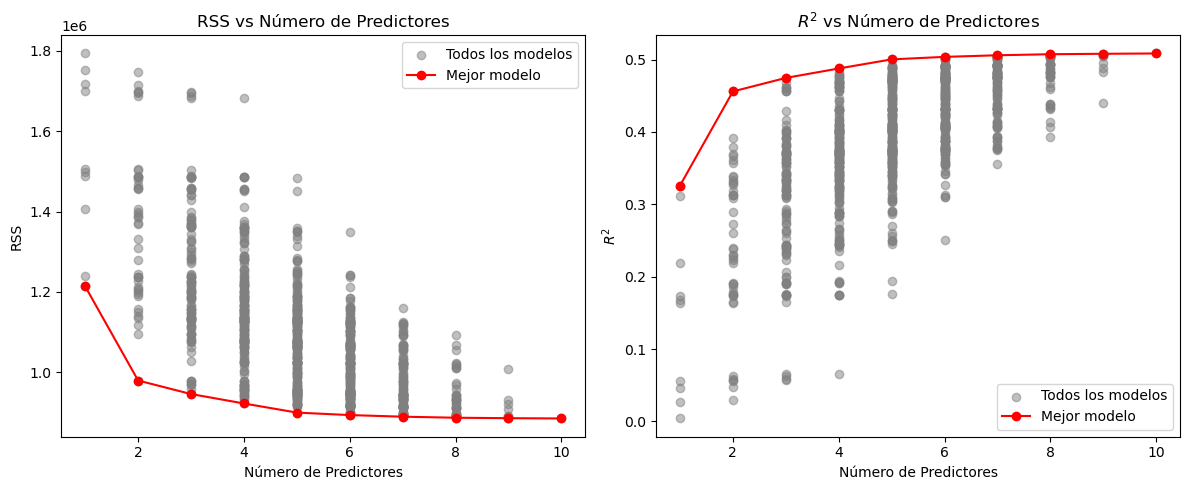

In [863]:
resultados_df, graficos = mejor_subconjunto(X_train, y_train, criterio='AIC', verbose=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RSS
axes[0].scatter(graficos['num_predictores'], graficos['rss_todos'], color='gray', alpha=0.5, label='Todos los modelos')
axes[0].plot(graficos['k_values'], graficos['rss_mejores'], '-o', color='red', label='Mejor modelo')
axes[0].set_xlabel('Número de Predictores')
axes[0].set_ylabel('RSS')
axes[0].set_title('RSS vs Número de Predictores')
axes[0].legend()

# R2
axes[1].scatter(graficos['num_predictores'], graficos['r2_todos'], color='gray', alpha=0.5, label='Todos los modelos')
axes[1].plot(graficos['k_values'], graficos['r2_mejores'], '-o', color='red', label='Mejor modelo')
axes[1].set_xlabel('Número de Predictores')
axes[1].set_ylabel('$R^2$')
axes[1].set_title('$R^2$ vs Número de Predictores')
axes[1].legend()

plt.tight_layout()
plt.show()


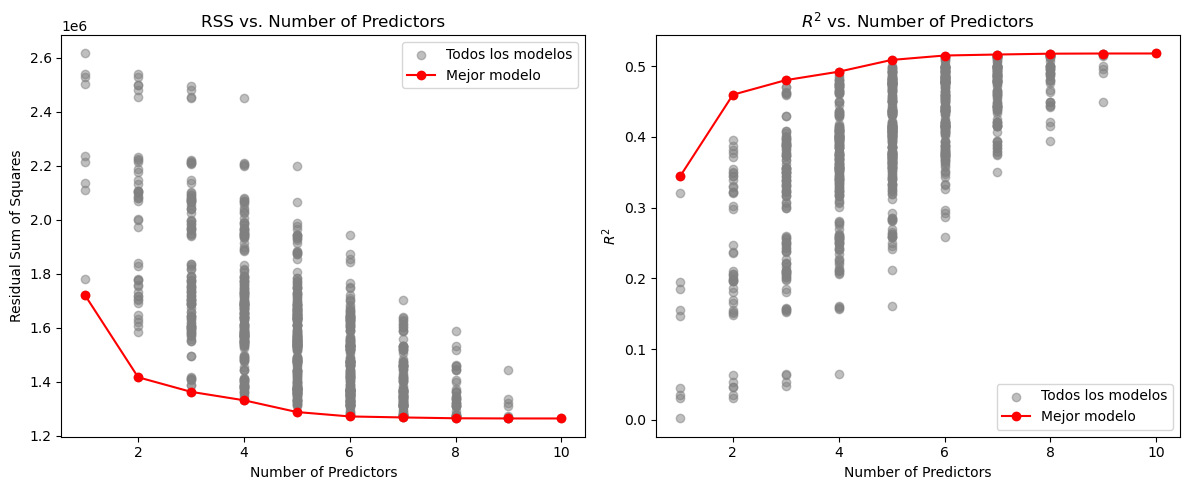

In [856]:
# Inicialización de listas para los gráficos
num_predictores = []
rss_todos = []
r2_todos = []

rss_mejores = []
r2_mejores = []
k_values = []

# Iterar por número de predictores (de 1 a p)
p = X.shape[1]
for k in range(1, p + 1):
    mejor_rss = np.inf
    mejor_r2 = -np.inf

    for subset in combinations(X.columns, k):
        X_k = add_constant(X[list(subset)])
        modelo = OLS(y, X_k).fit()
        rss = np.sum(modelo.resid ** 2)
        r2 = modelo.rsquared

        # Guardar todos los modelos (para los puntos grises)
        num_predictores.append(k)
        rss_todos.append(rss)
        r2_todos.append(r2)

        # Guardar el mejor modelo por k
        if rss < mejor_rss:
            mejor_rss = rss
        if r2 > mejor_r2:
            mejor_r2 = r2

    rss_mejores.append(mejor_rss)
    r2_mejores.append(mejor_r2)
    k_values.append(k)

# Graficar
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel RSS
axes[0].scatter(num_predictores, rss_todos, color='gray', alpha=0.5, label='Todos los modelos')
axes[0].plot(k_values, rss_mejores, '-o', color='red', label='Mejor modelo')
axes[0].set_xlabel('Number of Predictors')
axes[0].set_ylabel('Residual Sum of Squares')
axes[0].set_title('RSS vs. Number of Predictors')
axes[0].legend()

# Panel R²
axes[1].scatter(num_predictores, r2_todos, color='gray', alpha=0.5, label='Todos los modelos')
axes[1].plot(k_values, r2_mejores, '-o', color='red', label='Mejor modelo')
axes[1].set_xlabel('Number of Predictors')
axes[1].set_ylabel('$R^2$')
axes[1].set_title('$R^2$ vs. Number of Predictors')
axes[1].legend()

plt.tight_layout()
plt.show()

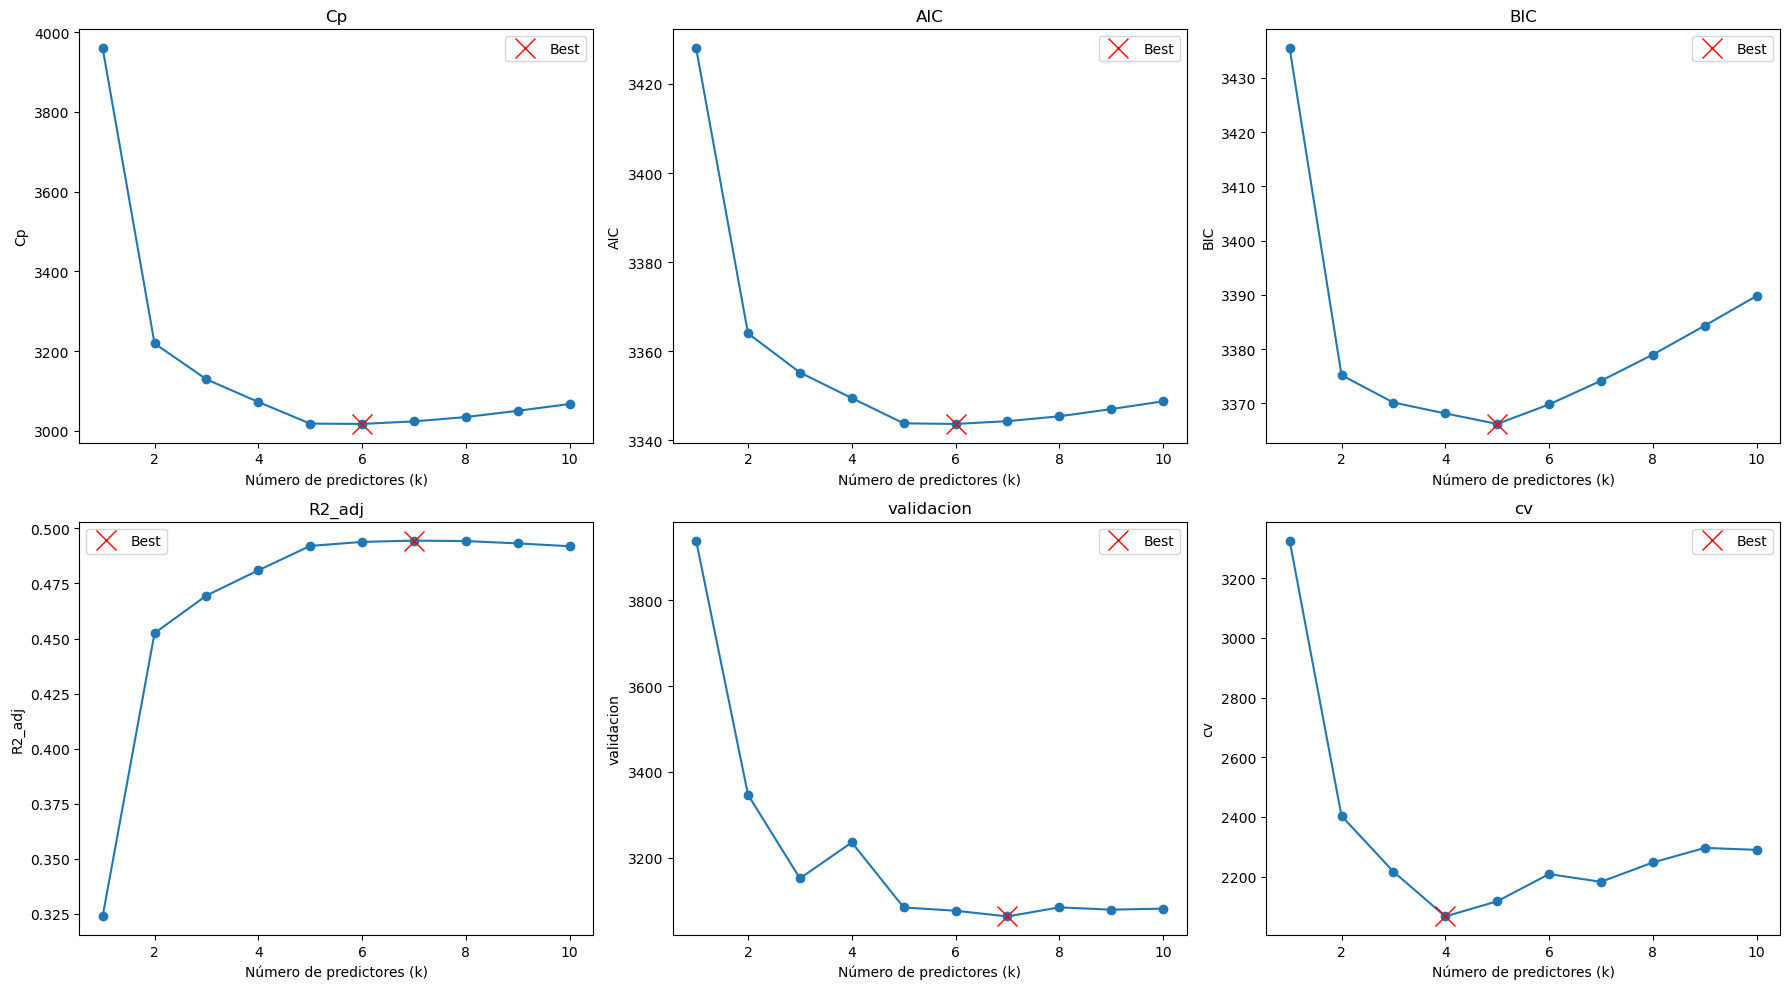

In [858]:
# Ejecutar función
resultados_df = mejor_subconjunto(X_train, y_train, criterio='AIC', X_val=X_val, y_val=y_val, k_cv=5, verbose=False)

# Crear gráficas
criterios = ['Cp', 'AIC', 'BIC', 'R2_adj', 'validacion', 'cv']
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.ravel()

for i, criterio in enumerate(criterios):
    data = resultados_df[['k', criterio]].dropna()
    axs[i].plot(data['k'], data[criterio], marker='o', linestyle='-')

    if criterio == 'R2_adj':
        best_idx = data[criterio].idxmax()
    else:
        best_idx = data[criterio].idxmin()

    best_k = data.loc[best_idx, 'k']
    best_val = data.loc[best_idx, criterio]

    axs[i].plot(best_k, best_val, 'x', markersize=15, label='Best', color='red')
    axs[i].set_title(criterio)
    axs[i].set_xlabel('Número de predictores (k)')
    axs[i].set_ylabel(criterio)
    axs[i].legend()

plt.tight_layout()
plt.show()

FIGURA 6.2 6.3

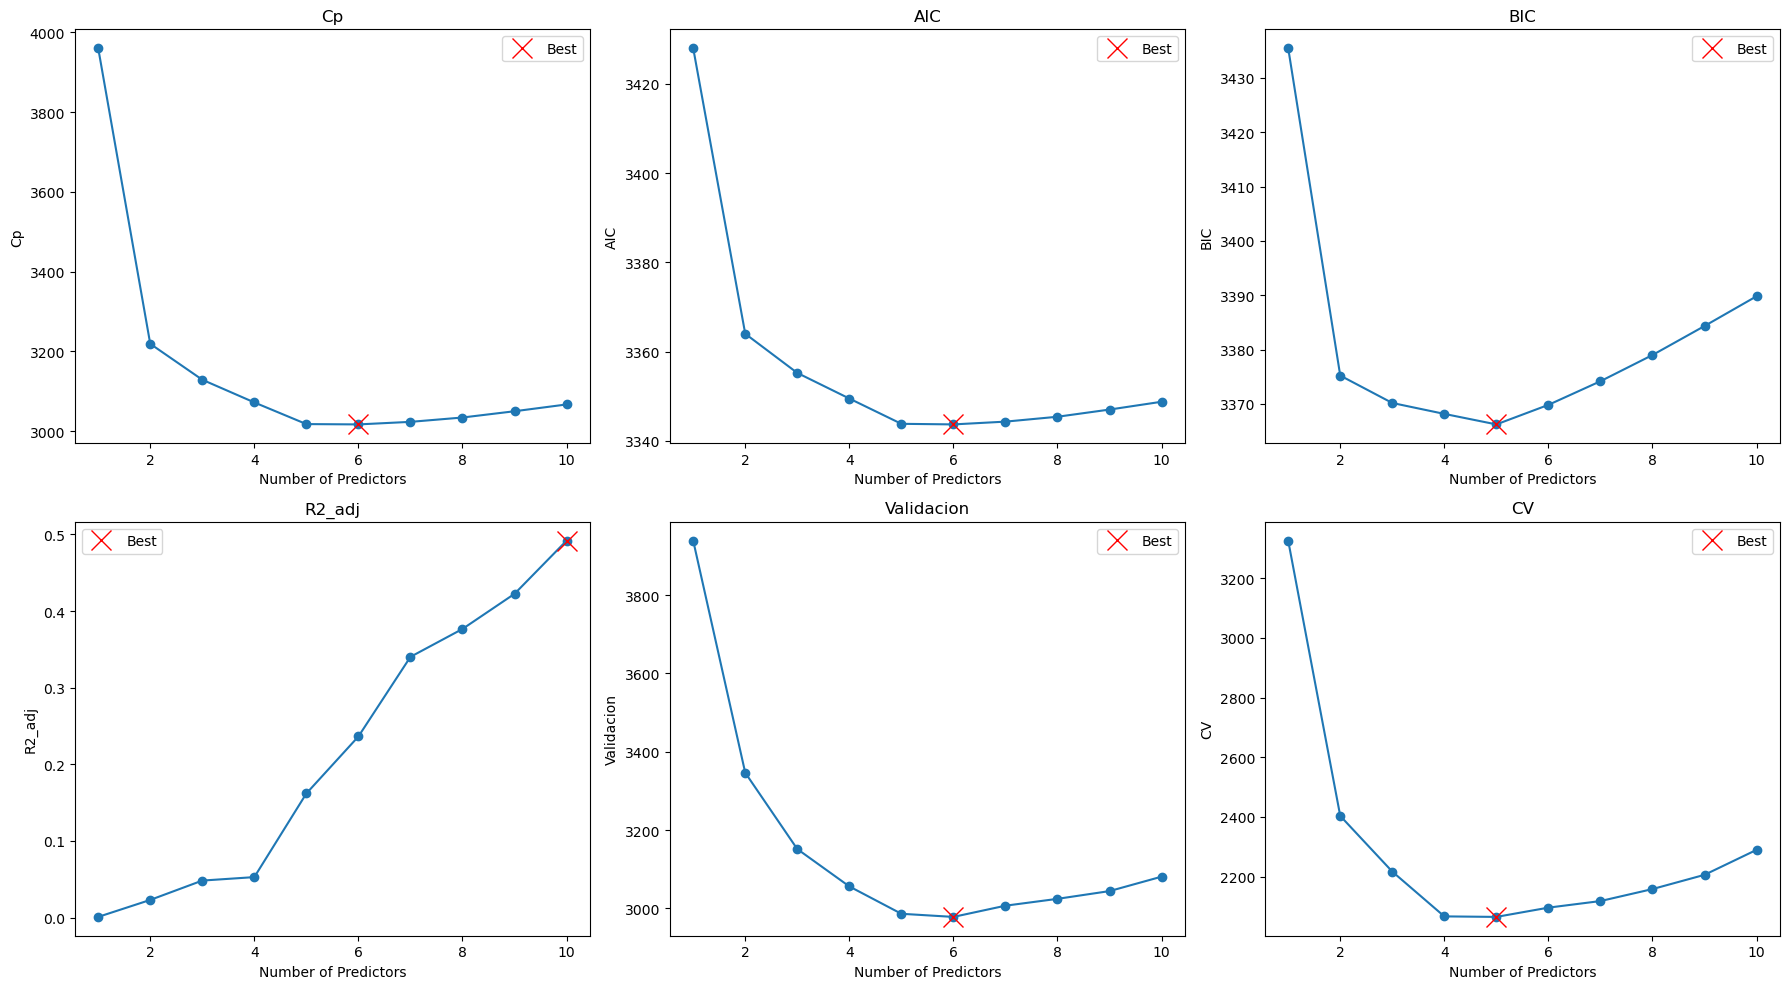

In [ ]:
# Función para evaluar todos los subconjuntos de predictores
def evaluar_modelos(X, y, X_val=None, y_val=None, k_cv=5):
    p = X.shape[1]
    predictores = X.columns
    n = len(y)
    resultados = []

    # Modelo completo para Cp
    X_full = add_constant(X)
    modelo_full = OLS(y, X_full).fit()
    sigma2_hat = modelo_full.scale

    for k in range(1, p + 1):
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])
            modelo = OLS(y, X_k).fit()
            rss = np.sum(modelo.resid ** 2)

            # Cp
            cp = (rss + 2 * k * sigma2_hat) / n

            # AIC y BIC
            aic = modelo.aic
            bic = modelo.bic

            # R2 ajustado
            r2_adj = modelo.rsquared_adj

            # Validación
            val_mse = np.nan
            if X_val is not None and y_val is not None:
                val_mse=validacion(modelo, X_val, y_val, list(subset))

            # Validación cruzada
            best_model_k, cv_mse , mse_scores_k = validacion_cruzada(X_train, y_train, list(subset), k_cv )

            resultados.append({
                'k': k,
                'predictores': subset,
                'Cp': cp,
                'AIC': aic,
                'BIC': bic,
                'R2_adj': r2_adj,
                'Validacion': val_mse,
                'CV': cv_mse
            })

    return pd.DataFrame(resultados)

# Evaluar modelos
resultados_df = evaluar_modelos(X_train, y_train, X_val, y_val)

# Gráficas
criterios = ['Cp', 'AIC', 'BIC', 'R2_adj', 'Validacion', 'CV']
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.ravel()

for i, criterio in enumerate(criterios):
    data = resultados_df.groupby('k')[criterio].min()
    axs[i].plot(data.index, data.values, marker='o', linestyle='-')
    best_k = data.idxmin() if criterio != 'R2_adj' else data.idxmax()
    best_val = data.min() if criterio != 'R2_adj' else data.max()
    axs[i].plot(best_k, best_val, 'x', markersize=15, label='Best', color='red')
    axs[i].set_title(criterio)
    axs[i].set_xlabel('Number of Predictors')
    axs[i].set_ylabel(criterio)
    axs[i].legend()

plt.tight_layout()
plt.show()


### Selección Paso a Paso hacia Adelante

Basado en el **Algortimo 2.2**

In [ ]:
def seleccion_paso_a_paso_adelante(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # Número de predictores
    n = len(y)  # Número de observaciones
    predictores = X.columns  # Nombres de las columnas de X
    predictores_restantes = set(predictores)  # Inicializa un conjunto con todos los predictores
    resultados_por_k = []  # Almacena los modelos seleccionados en cada paso

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale  # Estima sigma^2, el error cuadrático medio

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo que predice la media de y
    resultados_por_k.append({
        'k': 0,  # El modelo nulo tiene 0 predictores
        'modelo': modelo_nulo,
        'predictores': []
    })

    # Iterar sobre el número de predictores, desde 1 hasta p
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_predictores = None  # Inicializa la mejor combinación de predictores
        predictores_a_agregar = []  # Lista de predictores a agregar en cada paso
        
        # Evaluar todos los modelos que agregan un predictor adicional
        for predictor in predictores_restantes:
            predictores_a_probar = list(resultados_por_k[k-1]['predictores']) + [predictor]
            X_k = add_constant(X[predictores_a_probar])  # Agregar la constante
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS
            r2 = modelo.rsquared  # Obtiene el R² del modelo
            
            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = predictores_a_probar
                predictores_a_agregar = predictor

        # Después de elegir el mejor predictor, eliminarlo de los predictores restantes
        predictores_restantes.remove(predictores_a_agregar)

        # Almacena los resultados del paso k
        resultados_por_k.append({
            'k': k,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores,
        })

    # Inicializa las métricas para comparar modelos
    metricas = []
    mejores_modelos_cv = []

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            metricas.append(validacion(modelo, X_val, y_val, list(res['predictores'])))

        # Selección según validación cruzada
        elif criterio == 'cv':
            best_model_k, best_mse_k, mse_scores_k = validacion_cruzada(X_train, y_train, list(res['predictores']), k_cv )
            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica


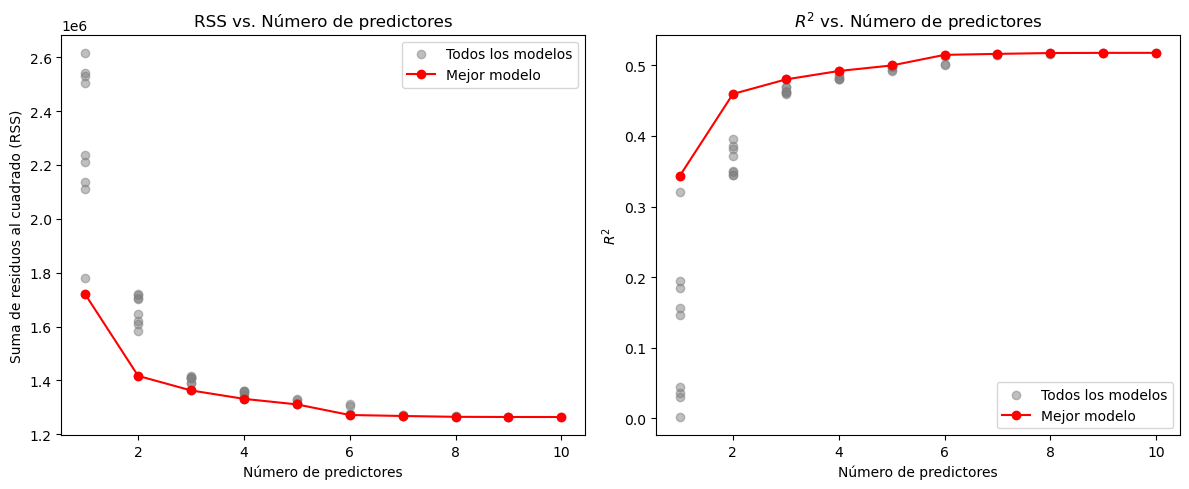

In [ ]:
# Inicialización de listas para los gráficos
num_predictores = []
rss_todos = []
r2_todos = []

rss_mejores = []
r2_mejores = []
k_values = []

# Predictores iniciales
p = X.shape[1]
predictores_restantes = set(X.columns)
predictores_seleccionados = []

# Iterar desde 1 hasta p predictores
for k in range(1, p + 1):
    mejor_rss = np.inf
    mejor_r2 = -np.inf
    mejor_predictor = None

    # Evaluar añadir cada predictor restante
    for predictor in predictores_restantes:
        candidatos = predictores_seleccionados + [predictor]
        X_k = add_constant(X[candidatos])
        modelo = OLS(y, X_k).fit()
        rss = np.sum(modelo.resid ** 2)
        r2 = modelo.rsquared

        # Guardar métricas de todos los modelos probados en este paso
        num_predictores.append(k)
        rss_todos.append(rss)
        r2_todos.append(r2)

        # Identificar el mejor modelo del paso actual
        if rss < mejor_rss:
            mejor_rss = rss
            mejor_r2 = r2
            mejor_predictor = predictor

    # Actualizar conjuntos y métricas del mejor modelo
    predictores_seleccionados.append(mejor_predictor)
    predictores_restantes.remove(mejor_predictor)

    rss_mejores.append(mejor_rss)
    r2_mejores.append(mejor_r2)
    k_values.append(k)

# Graficar resultados
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel RSS
axes[0].scatter(num_predictores, rss_todos, color='gray', alpha=0.5, label='Todos los modelos')
axes[0].plot(k_values, rss_mejores, '-o', color='red', label='Mejor modelo')
axes[0].set_xlabel('Número de predictores')
axes[0].set_ylabel('Suma de residuos al cuadrado (RSS)')
axes[0].set_title('RSS vs. Número de predictores')
axes[0].legend()

# Panel R²
axes[1].scatter(num_predictores, r2_todos, color='gray', alpha=0.5, label='Todos los modelos')
axes[1].plot(k_values, r2_mejores, '-o', color='red', label='Mejor modelo')
axes[1].set_xlabel('Número de predictores')
axes[1].set_ylabel('$R^2$')
axes[1].set_title('$R^2$ vs. Número de predictores')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Usar Cp:
modelo_forward_cp, valor_forward_cp = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 5
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex']
  Métrica (Cp): 3018.0770
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.60e-43
Time:                        18:56:39   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [ ]:
# Usar AIC:
modelo_forward_aic, valor_forward_aic = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 5
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex']
  Métrica (AIC): 3343.8415
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.60e-43
Time:                        18:56:39   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [ ]:
# Usar BIC:
modelo_forward_bic, valor_forward_bic = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 5
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex']
  Métrica (BIC): 3366.2221
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.60e-43
Time:                        18:56:39   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [ ]:
# Usar R2_adj:
modelo_forward_r2_adj, valor_forward_r2_adj = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 8
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex', 's1', 's4', 's2']
  Métrica (R2_adj): -0.4933
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     38.35
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.09e-41
Time:                        18:56:39   Log-Likelihood:                -1664.0
No. Observations:                 308   AIC:                             3346.
Df Residuals:                     299   BIC:                             3380.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [ ]:
# Usar validación (debe tener los datos de validación):
modelo_forward_val, mse_forward_val = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 6
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex', 's1']
  Métrica (validacion): 3036.5921
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     50.55
Date:                Thu, 15 May 2025   Prob (F-statistic):           8.21e-43
Time:                        18:56:40   Log-Likelihood:                -1665.4
No. Observations:                 308   AIC:                             3345.
Df Residuals:                     301   BIC:                             3371.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

In [ ]:
# Usar validación cruzada con k=5:
modelo_forward_cv, mse_forward_cv = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='cv', k_cv=5, verbose=True)


=== Mejor modelo según CV ===
  k = 4
  Predictores: ['bmi', 's5', 'bp', 's3']
  Mejor MSE en CV: 2066.7734
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     53.26
Date:                Thu, 15 May 2025   Prob (F-statistic):           3.77e-32
Time:                        18:56:40   Log-Likelihood:                -1348.2
No. Observations:                 247   AIC:                             2706.
Df Residuals:                     242   BIC:                             2724.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

### Selección Paso a Paso hacia Atrás

Basado en el **Algoritmo 2.3**

In [ ]:
def seleccion_paso_a_paso_atras(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # Número de predictores
    n = len(y)  # Número de observaciones
    predictores = X.columns  # Nombres de las columnas de X
    predictores_seleccionados = set(predictores)  # Inicializa un conjunto con todos los predictores
    resultados_por_k = []  # Almacena los modelos seleccionados en cada paso

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale

    # Modelo completo (con todos los predictores)
    X_completo = add_constant(X)  # Agregar la constante
    modelo_completo = OLS(y, X_completo).fit()
    resultados_por_k.append({
        'k': p,  # El modelo completo tiene p predictores
        'modelo': modelo_completo,
        'predictores': predictores.tolist()
    })

    # Iterar desde el número de predictores p hasta 1
    for k in range(p, 0, -1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_predictores = None  # Inicializa la mejor combinación de predictores
        predictores_a_eliminar = None  # Predictor a eliminar en cada paso
        
        # Evaluar todos los modelos que eliminan un predictor
        for predictor in predictores_seleccionados:
            predictores_a_probar = list(resultados_por_k[p - k]['predictores'])
            predictores_a_probar.remove(predictor)
            X_k = add_constant(X[predictores_a_probar])  # Agregar la constante
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS
            r2 = modelo.rsquared  # Obtiene el R² del modelo
            
            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = predictores_a_probar
                predictores_a_eliminar = predictor  # Corregir aquí: asignamos a la variable correcta

        # Después de elegir el mejor predictor, eliminarlo de los predictores seleccionados
        predictores_seleccionados.remove(predictores_a_eliminar)  # Usar la variable correcta

        # Almacena los resultados del paso k
        resultados_por_k.append({
            'k': k - 1,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores,
        })

    # Inicializa las métricas para comparar modelos
    metricas = []
    mejores_modelos_cv = []

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            metricas.append(validacion(modelo, X_val, y_val, list(res['predictores'])))

        # Selección según validación cruzada
        elif criterio == 'cv':
            best_model_k, best_mse_k, mse_scores_k = validacion_cruzada(X_train, y_train, list(res['predictores']), k_cv )
            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica

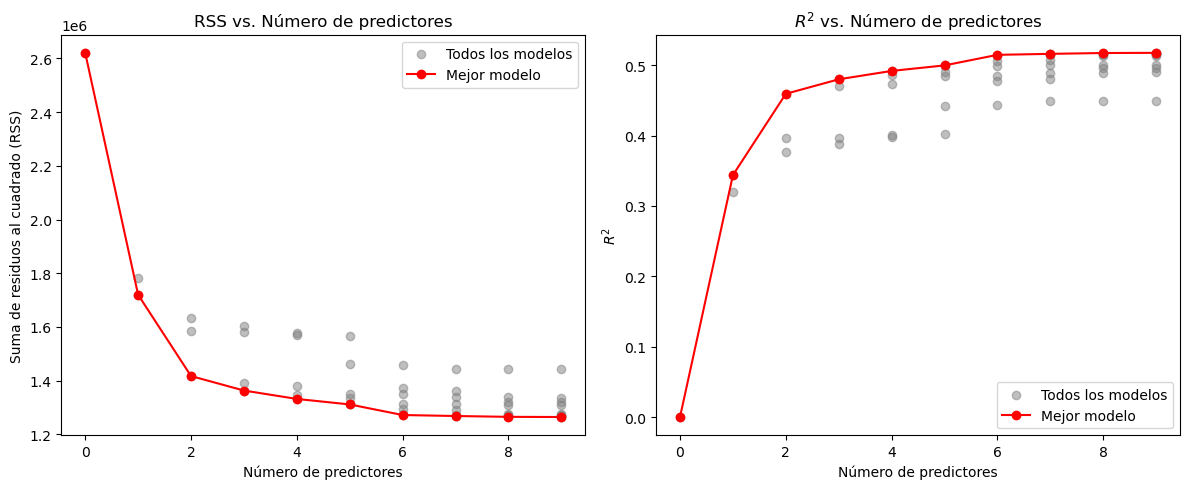

In [ ]:
# Inicialización de listas para los gráficos 
num_predictores = []
rss_todos = []
r2_todos = []

rss_mejores = []
r2_mejores = []
k_values = []

# Predictores iniciales
p = X.shape[1]
predictores_seleccionados = set(X.columns)

# Iterar desde p hasta 1 predictores (hacia atrás)
for k in range(p, 0, -1):
    mejor_rss = np.inf
    mejor_r2 = -np.inf
    mejor_modelo_k = None
    mejor_predictores = None
    predictor_a_eliminar = None

    for predictor in predictores_seleccionados:
        predictores_a_probar = list(predictores_seleccionados)
        predictores_a_probar.remove(predictor)
        X_k = add_constant(X[predictores_a_probar])
        modelo = OLS(y, X_k).fit()
        rss = np.sum(modelo.resid ** 2)
        r2 = modelo.rsquared

        # Guardar métricas de todos los modelos evaluados en este paso
        num_predictores.append(len(predictores_a_probar))
        rss_todos.append(rss)
        r2_todos.append(r2)

        # Mejor modelo del paso actual
        if r2 > mejor_r2:
            mejor_r2 = r2
            mejor_rss = rss
            mejor_modelo_k = modelo
            mejor_predictores = predictores_a_probar
            predictor_a_eliminar = predictor

    # Eliminar el predictor menos útil
    predictores_seleccionados.remove(predictor_a_eliminar)

    # Guardar métricas del mejor modelo de este paso
    rss_mejores.append(mejor_rss)
    r2_mejores.append(mejor_r2)
    k_values.append(len(mejor_predictores))

# Ordenar los resultados para que el eje X vaya de 0 a p
orden = np.argsort(k_values)

# Graficar resultados
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel RSS
axes[0].scatter(np.array(num_predictores), rss_todos, color='gray', alpha=0.5, label='Todos los modelos')
axes[0].plot(np.array(k_values)[orden], np.array(rss_mejores)[orden], '-o', color='red', label='Mejor modelo')
axes[0].set_xlabel('Número de predictores')
axes[0].set_ylabel('Suma de residuos al cuadrado (RSS)')
axes[0].set_title('RSS vs. Número de predictores')
axes[0].legend()

# Panel R²
axes[1].scatter(np.array(num_predictores), r2_todos, color='gray', alpha=0.5, label='Todos los modelos')
axes[1].plot(np.array(k_values)[orden], np.array(r2_mejores)[orden], '-o', color='red', label='Mejor modelo')
axes[1].set_xlabel('Número de predictores')
axes[1].set_ylabel('$R^2$')
axes[1].set_title('$R^2$ vs. Número de predictores')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Usar Cp:
modelo_backward_cp, valor_backward_cp = seleccion_paso_a_paso_atras(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (Cp): 3017.2779
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.70e-43
Time:                        18:56:42   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [ ]:
# Usar AIC:
modelo_backward_aic, valor_backward_aic = seleccion_paso_a_paso_atras(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (AIC): 3343.7095
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.70e-43
Time:                        18:56:42   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [ ]:
# Usar BIC:
modelo_backward_bic, valor_backward_bic = seleccion_paso_a_paso_atras(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (BIC): 3369.8202
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.70e-43
Time:                        18:56:42   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [ ]:
# Usar R2_adj:
modelo_backward_r2_adj, valor_backward_r2_adj = seleccion_paso_a_paso_atras(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 7
  Predictores: ['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5']
  Métrica (R2_adj): -0.4945
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     43.90
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.81e-42
Time:                        18:56:42   Log-Likelihood:                -1664.2
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     300   BIC:                             3374.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

In [ ]:
# Usar validación (debe tener los datos de validación):
modelo_backward_val, mse_backward_val = seleccion_paso_a_paso_atras(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 7
  Predictores: ['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5']
  Métrica (validacion): 3062.6161
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     43.90
Date:                Thu, 15 May 2025   Prob (F-statistic):           1.81e-42
Time:                        18:56:43   Log-Likelihood:                -1664.2
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     300   BIC:                             3374.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

In [ ]:
# Usar validación cruzada con k=5:
modelo_backward_cv, mse_backward_cv = seleccion_paso_a_paso_atras(X_train, y_train, criterio='cv', k_cv=5, verbose=True)


=== Mejor modelo según CV ===
  k = 5
  Predictores: ['bmi', 'bp', 's1', 's4', 's5']
  Mejor MSE en CV: 2147.0146
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     43.85
Date:                Thu, 15 May 2025   Prob (F-statistic):           4.64e-32
Time:                        18:56:43   Log-Likelihood:                -1346.3
No. Observations:                 247   AIC:                             2705.
Df Residuals:                     241   BIC:                             2726.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

# Métodos de Penalización

Es muy importante estandarizar los datos, ya que los modelos siguientes son muy sensibles a la escala. Aunque nuestros datos ya están estandarizados, a continuación te muestro cómo se realizaría este proceso.

NOTA: El parámetro $\lambda$ se llama alpha en Sklearn. 

In [ ]:
# Escalar
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

### Ridge Regression

Si simplemente queremos saber cuáles son los coeficientes que calcula la Ridge Regression para un valor específico de $\lambda$ (alpha), podemos utilizar la función **Ridge()** del módulo sklearn.linear_model. Esta permite ajustar el modelo con un valor fijo de regularización y obtener directamente los coeficientes.

In [ ]:
# Crear el modelo Ridge con un valor de alpha (λ) de 10
ridge = Ridge(alpha=1)

# Ajustar el modelo Ridge a los datos estandarizados de entrenamiento
ridge.fit(X_train, y_train)

# Crear un DataFrame con los coeficientes del modelo y los nombres de las características (predictores)
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Columnas de las características del conjunto de datos de entrenamiento
    'Coefficient': ridge.coef_   # Coeficientes obtenidos por el modelo Ridge
})

# Agregar una nueva columna con los valores absolutos de los coeficientes
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Ordenar el DataFrame según el valor absoluto de los coeficientes en orden descendente
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Imprimir los coeficientes ordenados, mostrando los más influyentes primero
print("\nCoeficientes de la regresión Ridge:")
print(coef_df)


Coeficientes de la regresión Ridge:
  Feature  Coefficient  Abs_Coefficient
2     bmi   251.896962       251.896962
8      s5   221.449273       221.449273
3      bp   159.842119       159.842119
6      s3  -140.443540       140.443540
7      s4   127.552592       127.552592
9      s6   117.124198       117.124198
1     sex   -47.788039        47.788039
4      s1    26.823217        26.823217
0     age    16.617407        16.617407
5      s2     3.430260         3.430260


En cambio, si queremos encontrar para qué valor de $\lambda$ (alpha) se obtiene el mejor modelo, podemos utilizar **RidgeCV**, que realiza una validación cruzada para seleccionar automáticamente el valor óptimo de alpha. Este proceso evalúa el rendimiento del modelo en diferentes particiones de los datos y elige el alpha que minimiza el error.

NOTA: Si no especificamos sobre que alphas queremos que trabaje RidgeCV(), por defecto, trabajara con alphas=[0.1, 1.0, 10.0]

El valor óptimo de alpha es: 0.1

Coeficientes del mejor modelo (Ridge Regression):
  Feature  Coefficient  Abs_Coefficient
2     bmi   471.746709       471.746709
8      s5   403.375788       403.375788
3      bp   272.318939       272.318939
6      s3  -174.351515       174.351515
1     sex  -169.351439       169.351439
7      s4   152.561617       152.561617
9      s6   112.584900       112.584900
5      s2   -58.438721        58.438721
4      s1   -41.240039        41.240039
0     age   -28.970900        28.970900

MSE en entrenamiento: 2912.8657
R² en entrenamiento: 0.5018


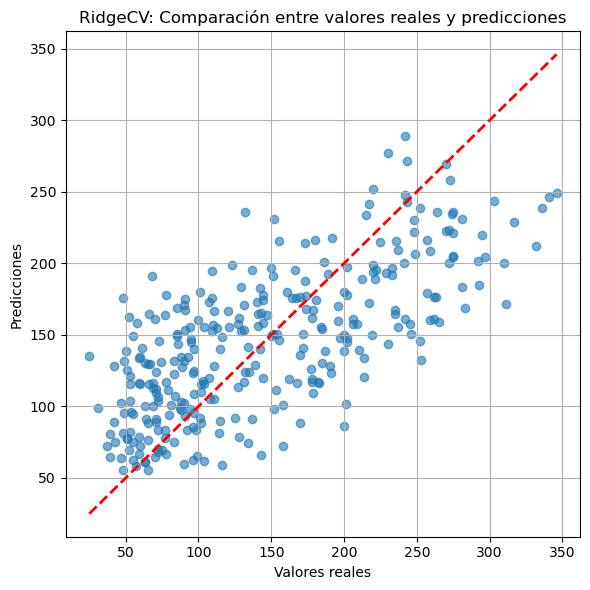

In [ ]:
# Definir valores de alpha (desde 10^-6 a 10^6)
alphas = np.logspace(-6, 6, 13)

# Ajustar modelo RidgeCV con validación cruzada
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"El valor óptimo de alpha es: {ridge_cv.alpha_}")

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (Ridge Regression):")
print(coef_df) 

# Hacer predicciones en los datos de entrenamiento
y_pred = ridge_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('RidgeCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Calcular el error cuadrático medio (MSE) promedio de la validación cruzada para cada valor de alpha (λ)
cv_mse = np.mean(ridge_cv.cv_values_, axis=0)

# Crear un DataFrame para almacenar los resultados, incluyendo los valores de alpha y los MSE promedio
results_df = pd.DataFrame({
    'Alpha (lambda)': ridge_cv.alphas,  # Valores de alpha (λ) utilizados en la validación cruzada
    'Mean Val Score (MSE)': cv_mse    # MSE promedio obtenido para cada valor de alpha
})

# Añadir una columna con el ranking de los MSE (menor MSE tiene el rango más alto)
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar el DataFrame por el ranking de MSE, de menor a mayor MSE
results_df = results_df.sort_values(by='Rank Val Score')

# Imprimir el DataFrame resultante para mostrar los valores de alpha y sus respectivos rankings de MSE
print(results_df)

    Alpha (lambda)  Mean Val Score (MSE)  Rank Val Score
5         0.100000           3075.591956             1.0
4         0.010000           3082.373666             2.0
3         0.001000           3088.097186             3.0
2         0.000100           3090.340110             4.0
1         0.000010           3090.634208             5.0
0         0.000001           3090.664503             6.0
6         1.000000           3491.251685             7.0
7        10.000000           5028.315134             8.0
8       100.000000           5770.694300             9.0
9      1000.000000           5872.871951            10.0
10    10000.000000           5883.469126            11.0
11   100000.000000           5884.532772            12.0
12  1000000.000000           5884.639176            13.0


Otra forma seria aplicando **GridSearchCV** al Ridge(). Siempre tenemos que especificar los valores de alpha con los que queremos que trabaje. 

In [ ]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con Ridge
grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto de entrenamiento y validación
grid_search.fit(X_train, y_train)

# Ver el mejor modelo
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame para mostrar los resultados de manera ordenada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],  # Negamos para obtener el valor positivo
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de la prueba (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar el mejor valor de alpha que eligió GridSearchCV
print(f"\nMejor valor de alpha (lambda) seleccionado: {grid_search.best_params_['alpha']}")

# Obtener los coeficientes del mejor modelo
coefficients = best_model.coef_

# Crear un DataFrame para mostrar los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Si X_train es un DataFrame con nombres de columna
    'Coefficient': coefficients
})

# Ordenar los coeficientes por valor absoluto para ver cuáles tienen mayor impacto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo:")
print(coef_df)



Mejor valor de alpha (lambda) seleccionado: 0.01

Coeficientes del mejor modelo:
  Feature  Coefficient  Abs_Coefficient
8      s5   533.467611       533.467611
2     bmi   523.140149       523.140149
3      bp   300.232334       300.232334
4      s1  -280.727226       280.727226
1     sex  -202.988620       202.988620
7      s4   186.593104       186.593104
5      s2    95.590412        95.590412
9      s6    90.348538        90.348538
6      s3   -73.365675        73.365675
0     age   -43.382400        43.382400


In [ ]:
print("Resultados de la búsqueda con validación cruzada (Ridge Regression):")
results_df

Resultados de la búsqueda con validación cruzada (Ridge Regression):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
4,0.01,3062.922792,263.657827,2863.207022,56.366775,1
3,0.001,3063.956695,272.333671,2853.904565,56.441795,2
2,0.0001,3065.078244,275.017925,2853.310148,56.472073,3
1,0.00001,3065.260423,275.357147,2853.301854,56.472586,4
0,0.000001,3065.279616,275.391983,2853.301768,56.472591,5
5,0.1,3068.023611,264.131846,2904.672677,57.306585,6
6,1.0,3593.277855,460.922156,3499.552067,77.398375,7
7,10.0,5135.419508,876.951235,5102.929085,178.047026,8
8,100.0,5762.614337,1002.179115,5751.331382,244.334792,9
9,1000.0,5844.237353,1017.017987,5835.734684,253.847115,10


Cuando el espacio de hiperparámetros es muy amplio o el costo computacional de evaluar todas las combinaciones posibles es alto, existen alternativas más eficientes a **GridSearchCV**. Una de ellas es **RandomizedSearchCV**, que selecciona combinaciones de hiperparámetros de manera aleatoria, permitiendo controlar el número de pruebas a realizar. Esta estrategia reduce el tiempo de búsqueda en comparación con una exploración exhaustiva.

Como punto intermedio entre una búsqueda exhaustiva y una aleatoria, **HalvingRandomSearchCV** ofrece una solución aún más eficiente. Este método comienza evaluando muchas combinaciones utilizando una fracción reducida de los datos y, en cada iteración, incrementa el tamaño de la muestra. A medida que avanza, se enfoca solo en los modelos que han mostrado un mejor desempeño, lo que permite ahorrar tiempo sin sacrificar una gran precisión en la selección de los hiperparámetros.

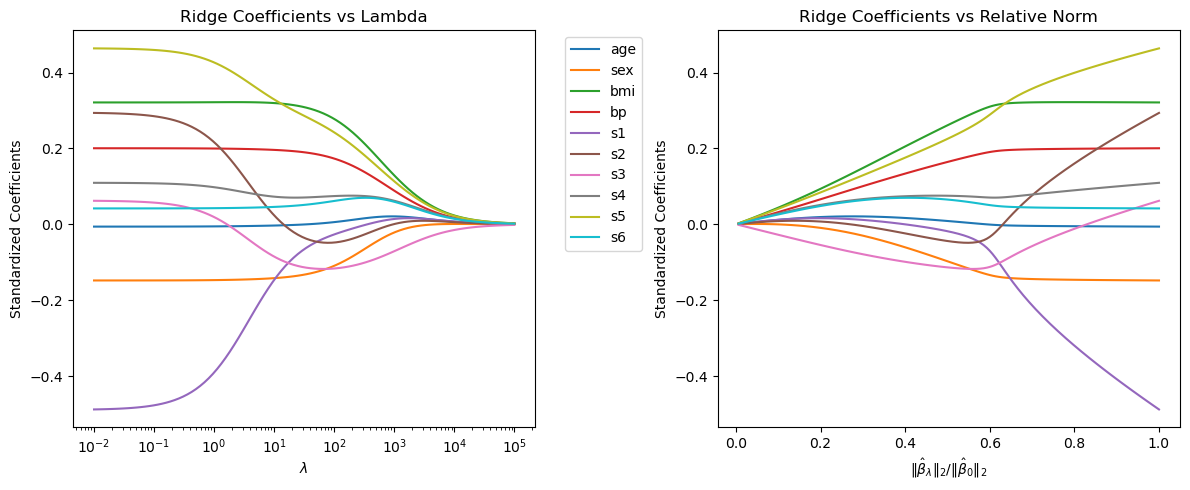

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Suponiendo que ya tienes X (DataFrame) e y definidos
X_std = StandardScaler().fit_transform(X)
y_std = (y - y.mean()) / y.std()

coefs = []
lambdas = np.logspace(-2, 5, 100)

# Ajustamos Ridge para cada valor de lambda
for l in lambdas:
    ridge = Ridge(alpha=l, fit_intercept=False)
    ridge.fit(X_std, y_std)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Creamos la gráfica
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Izquierda: Coeficientes vs lambda
for i in range(X.shape[1]):
    axes[0].plot(lambdas, coefs[:, i])
axes[0].set_xscale('log')
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('Standardized Coefficients')
axes[0].set_title('Ridge Coefficients vs Lambda')
axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Derecha: Coef vs norma relativa
norms = np.linalg.norm(coefs, axis=1) / np.linalg.norm(coefs[0])
for i in range(X.shape[1]):
    axes[1].plot(norms, coefs[:, i])
axes[1].set_xlabel(r'$\|\hat{\beta}_\lambda\|_2 / \|\hat{\beta}_0\|_2$')
axes[1].set_ylabel('Standardized Coefficients')
axes[1].set_title('Ridge Coefficients vs Relative Norm')

plt.tight_layout()
plt.show()


### LASSO

Todo lo visto anteriormente con el Ridge Regression se puede aplicar también al LASSO

In [ ]:
# Ajustar el modelo LASSO con un valor específico de alpha
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df_lasso = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})

# Añadir columna con los valores absolutos
coef_df_lasso['Abs_Coefficient'] = coef_df_lasso['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df_lasso = coef_df_lasso.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del modelo LASSO")
print(coef_df_lasso)


Coeficientes del modelo LASSO
  Feature  Coefficient  Abs_Coefficient
2     bmi   530.625396       530.625396
8      s5   530.212964       530.212964
3      bp   297.336082       297.336082
4      s1  -254.811341       254.811341
1     sex  -197.390983       197.390983
7      s4   188.926728       188.926728
9      s6    83.258877        83.258877
6      s3   -74.270787        74.270787
5      s2    66.338186        66.338186
0     age   -38.398183        38.398183


Si no especificamos sobre que alphas queremos que LassoCV() trabaje, este genera automáticamente una secuencia de valores basada en los datos de entrada. LassoCV calcula internamente un valor máximo de alpha (alpha_max) a partir de los datos, que es el menor valor de alpha tal que todos los coeficientes del modelo son cero. Luego crea por defecto una secuencia de n_alphas=100 valores, logarítmicamente espaciados entre alpha_max y alpha_max * 1e-3.

El valor óptimo de alpha es: 0.004158

Coeficientes del mejor modelo (Lasso):
  Feature  Coefficient  Abs_Coefficient
8      s5   607.712065       607.712065
2     bmi   525.938143       525.938143
4      s1  -459.955946       459.955946
3      bp   302.483021       302.483021
5      s2   237.225313       237.225313
1     sex  -206.669757       206.669757
7      s4   201.462047       201.462047
9      s6    82.570388        82.570388
0     age   -42.415011        42.415011
6      s3     0.000000         0.000000

MSE en entrenamiento: 2876.6420
R² en entrenamiento: 0.5080


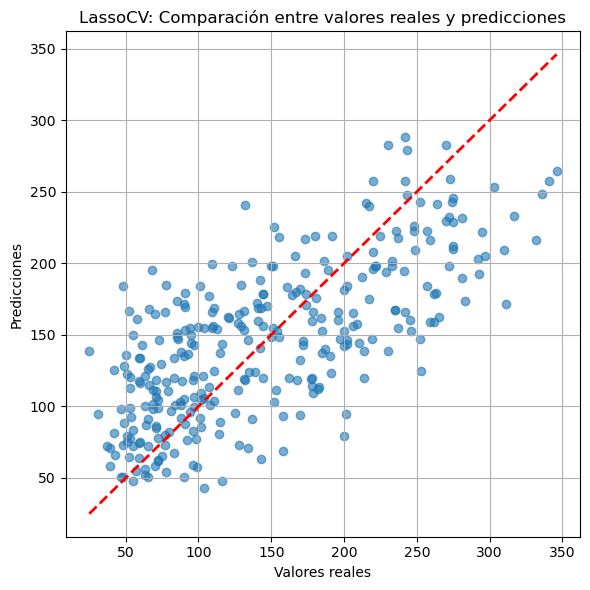

In [ ]:
# Ajustar modelo LassoCV con validación cruzada
lasso_cv = LassoCV(cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"El valor óptimo de alpha es: {lasso_cv.alpha_:.6f}")

# Crear DataFrame con coeficientes y ordenarlos por impacto
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar top 10 características más relevantes
print("\nCoeficientes del mejor modelo (Lasso):")
print(coef_df.head(10))

# Hacer predicciones en los datos de entrenamiento
y_pred = lasso_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs. valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('LassoCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Obtener el MSE promedio por alpha
cv_mse = np.mean(lasso_cv.mse_path_, axis=1)

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Alpha (lambda)': lasso_cv.alphas_,  # Valores de alpha evaluados
    'Mean Val Score (MSE)': cv_mse       # MSE promedio para cada alpha
})

# Añadir ranking por MSE (menor MSE = mejor alpha)
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar por el mejor desempeño
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar resultados
print(results_df)

    Alpha (lambda)  Mean Val Score (MSE)  Rank Val Score
89        0.004158           3066.035173             1.0
90        0.003878           3066.038971             2.0
91        0.003617           3066.055567             3.0
92        0.003373           3066.084013             4.0
93        0.003146           3066.121039             5.0
..             ...                   ...             ...
4         1.565560           4886.953265            96.0
3         1.678699           5099.975660            97.0
2         1.800014           5332.421093            98.0
1         1.930096           5599.340963            99.0
0         2.069579           5790.615456           100.0

[100 rows x 3 columns]


In [ ]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con Lasso
grid_search = GridSearchCV(
    estimator=Lasso(max_iter=10000),  # Aumentamos max_iter para evitar warnings de convergencia
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto combinado (ya escalado)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame con los resultados de la validación cruzada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de validación (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo Lasso
coefficients = best_model.coef_

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Ordenar los coeficientes por su valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo Lasso (alpha = {best_model.alpha}):")
print(coef_df)


Coeficientes del mejor modelo Lasso (alpha = 1e-06):
  Feature  Coefficient  Abs_Coefficient
4      s1  -727.037002       727.037002
8      s5   703.620120       703.620120
2     bmi   523.336488       523.336488
5      s2   444.996652       444.996652
3      bp   307.061116       307.061116
7      s4   246.174177       246.174177
1     sex  -212.878323       212.878323
6      s3   123.133199       123.133199
9      s6    80.538932        80.538932
0     age   -46.102722        46.102722


In [ ]:
print("Resultados de la búsqueda con validación cruzada (Lasso):")
results_df

Resultados de la búsqueda con validación cruzada (Lasso):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
0,0.000001,3065.281801,275.394194,2853.301767,56.472591,1
1,0.00001,3065.282189,275.379174,2853.301787,56.472590,2
2,0.0001,3065.288391,275.230069,2853.303791,56.472488,3
3,0.001,3065.579726,273.847307,2853.504077,56.462267,4
4,0.01,3072.178720,262.688619,2861.959290,57.570919,5
5,0.1,3087.707885,222.031414,2910.959760,54.905849,6
6,1.0,3939.541499,583.240983,3791.249344,57.171449,7
7,10.0,5853.579820,1018.696580,5845.395912,254.947897,8
8,100.0,5853.579820,1018.696580,5845.395912,254.947897,8
9,1000.0,5853.579820,1018.696580,5845.395912,254.947897,8


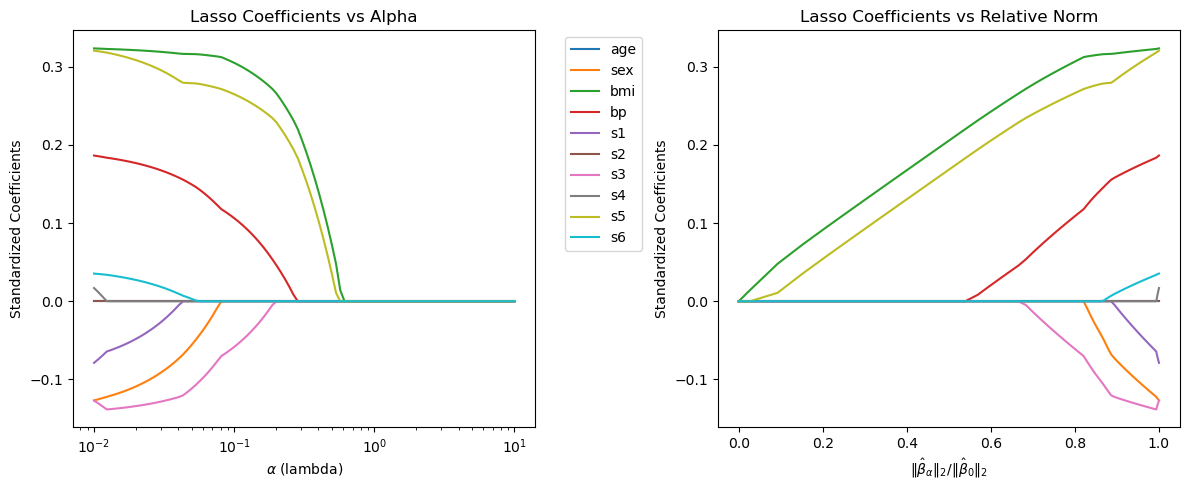

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Supongo que ya tienes X (DataFrame) e y definidos
X_std = StandardScaler().fit_transform(X)
y_std = (y - y.mean()) / y.std()

coefs = []
alphas = np.logspace(-2, 1, 100)  # Valores para el parámetro alpha (lambda)

for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False, max_iter=10000)
    lasso.fit(X_std, y_std)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfica 1: coeficientes vs alpha (lambda)
for i in range(X.shape[1]):
    axes[0].plot(alphas, coefs[:, i])
axes[0].set_xscale('log')
axes[0].set_xlabel(r'$\alpha$ (lambda)')
axes[0].set_ylabel('Standardized Coefficients')
axes[0].set_title('Lasso Coefficients vs Alpha')
axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfica 2: coeficientes vs norma relativa
norms = np.linalg.norm(coefs, axis=1) / np.linalg.norm(coefs[0])
for i in range(X.shape[1]):
    axes[1].plot(norms, coefs[:, i])
axes[1].set_xlabel(r'$\|\hat{\beta}_\alpha\|_2 / \|\hat{\beta}_0\|_2$')
axes[1].set_ylabel('Standardized Coefficients')
axes[1].set_title('Lasso Coefficients vs Relative Norm')

plt.tight_layout()
plt.show()


### ElasticNet

ElasticNet es un modelo de regresión lineal regularizada que combina las penalizaciones de Lasso (L1) y Ridge (L2).

Es ideal cuando:
- Hay muchas variables predictoras.
- Existe multicolinealidad entre las variables.
- Se quiere un equilibrio entre selección de variables y estabilidad del modelo.

Minimiza:

$\text{RSS} + \alpha \left( \lambda \sum | \beta_j | + (1 - \lambda) \sum \beta_j^2 \right)$

Donde:
- RSS: Suma de errores cuadrados.
- $\alpha$ (alpha): Controla la fuerza de la regularización.
- $\lambda$ (l1_ratio): Controla la proporción entre Lasso (L1) y Ridge (L2).

  - l1_ratio = 1 → Lasso puro.
  - l1_ratio = 0 → Ridge puro.


#####  Ventajas del ElasticNet

- Selecciona automáticamente variables relevantes (como Lasso).
- Reduce la varianza y mejora la estabilidad en presencia de multicolinealidad (como Ridge).
- Útil cuando:
  - Hay más variables que observaciones.
  - Lasso por sí solo elimina demasiadas variables importantes.
  - Las variables están correlacionadas entre sí.


##### Implementación en scikit-learn

- ElasticNet: Ajuste manual de alpha y l1_ratio.
- ElasticNetCV: Selección automática de los mejores hiperparámetros mediante validación cruzada.

In [ ]:
# Ajustar el modelo ElasticNet con valores específicos de alpha y l1_ratio
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5, max_iter=10000)
elastic_net.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_net.coef_
})

# Añadir columna para los coeficientes en valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del ElasticNet")
print(coef_df)


Coeficientes del ElasticNet
  Feature  Coefficient  Abs_Coefficient
8      s5     3.099037         3.099037
2     bmi     3.010161         3.010161
7      s4     2.346129         2.346129
6      s3    -2.040421         2.040421
3      bp     1.969172         1.969172
9      s6     1.847214         1.847214
4      s1     0.611880         0.611880
5      s2     0.443049         0.443049
0     age     0.186116         0.186116
1     sex     0.000000         0.000000


Si no especificamos los parámteros alpha y l1_ratio en ElasticNetCV(), los parámetros alpha son escogidos al igual que en LassoCV(), mientras que el l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1].

Mejor alpha encontrado: 0.004139157400766346
Mejor l1_ratio encontrado: 0.50

Coeficientes del mejor modelo (ElasticNet):
  Feature  Coefficient  Abs_Coefficient
2     bmi   305.558537       305.558537
8      s5   263.126161       263.126161
3      bp   188.345164       188.345164
6      s3  -156.823447       156.823447
7      s4   137.033206       137.033206
9      s6   125.330255       125.330255
1     sex   -73.613622        73.613622
4      s1    17.546112        17.546112
5      s2   -11.282796        11.282796
0     age     7.971627         7.971627

MSE en entrenamiento: 3207.5806
R² en entrenamiento: 0.4514


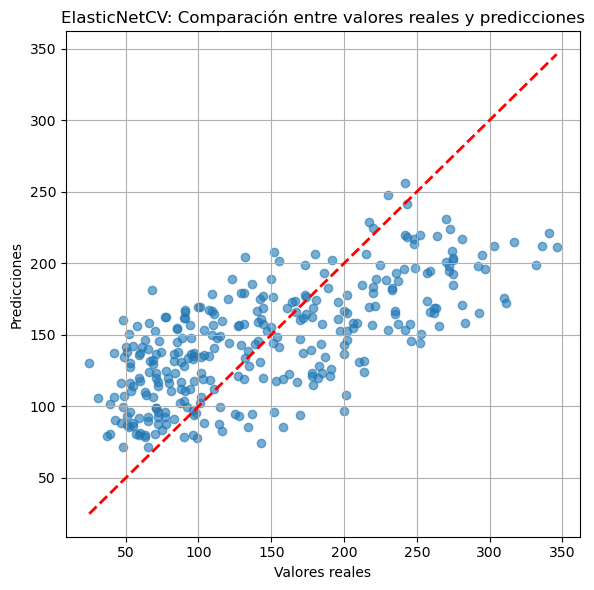

In [ ]:
# Ajustar modelo ElasticNetCV con validación cruzada
elastic_cv = ElasticNetCV(cv=5, max_iter=10000)
elastic_cv.fit(X_train, y_train)

# Mostrar el mejor alpha y l1_ratio encontrados
print(f"Mejor alpha encontrado: {elastic_cv.alpha_}")
print(f"Mejor l1_ratio encontrado: {elastic_cv.l1_ratio_:.2f}")

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (ElasticNet):")
print(coef_df.head(10))  # Top 10 características más relevantes

# Hacer predicciones en los datos de entrenamiento
y_pred = elastic_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('ElasticNetCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Obtener el MSE promedio por alpha para el mejor l1_ratio encontrado
cv_mse = np.mean(elastic_cv.mse_path_, axis=1)  # promedio sobre las folds

# Crear DataFrame con los resultados
results_df = pd.DataFrame({
    'Alpha (lambda)': elastic_cv.alphas_,
    'Mean Val Score (MSE)': cv_mse
})

# Agregar ranking de MSE
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')

# Ordenar por ranking
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar resultados
print(f"Mejor combinación encontrada: alpha = {elastic_cv.alpha_}, l1_ratio = {elastic_cv.l1_ratio_}")
print("\nResultados por alpha para el mejor l1_ratio:")
print(results_df)

Mejor combinación encontrada: alpha = 0.004139157400766346, l1_ratio = 0.5

Resultados por alpha para el mejor l1_ratio:
    Alpha (lambda)  Mean Val Score (MSE)  Rank Val Score
99        0.004139           3307.946196             1.0
98        0.004438           3331.352623             2.0
97        0.004759           3356.306032             3.0
96        0.005103           3382.723482             4.0
95        0.005472           3410.638544             5.0
..             ...                   ...             ...
4         3.131121           5850.961503            96.0
3         3.357398           5851.883471            97.0
2         3.600028           5852.587667            98.0
1         3.860192           5853.131005            99.0
0         4.139157           5853.469746           100.0

[100 rows x 3 columns]


In [ ]:
# Definir el grid de valores para alpha (lambda) y l1_ratio (mezcla entre LASSO y Ridge)
param_grid = {
    'alpha': np.logspace(-3, 3, 7),
    'l1_ratio': np.append(0.01, np.linspace(0.1, 1.0, 19))  # 0 es Ridge, 1 es LASSO
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con ElasticNet
grid_search = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto de entrenamiento y validación
grid_search.fit(X_train, y_train)

# Ver el mejor modelo
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame para mostrar los resultados de manera ordenada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'L1 Ratio': results['param_l1_ratio'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de la prueba (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar los resultados
#print("\nResultados de la búsqueda con validación cruzada (ElasticNet):")
#print(results_df)

# Obtener los coeficientes del mejor modelo ElasticNet
coefficients = best_model.coef_

# Crear un DataFrame para mostrar los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Si X_train es un DataFrame con nombres de columna
    'Coefficient': coefficients
})

# Ordenar los coeficientes por valor absoluto para ver cuáles tienen mayor impacto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"Coeficientes del mejor modelo: {best_model}")
print(coef_df)


Coeficientes del mejor modelo: ElasticNet(alpha=0.001, l1_ratio=0.8)
  Feature  Coefficient  Abs_Coefficient
2     bmi   492.815805       492.815805
8      s5   429.198560       429.198560
3      bp   282.419540       282.419540
1     sex  -181.335168       181.335168
6      s3  -165.793657       165.793657
7      s4   155.356078       155.356078
9      s6   105.550637       105.550637
4      s1   -67.055244        67.055244
5      s2   -50.686033        50.686033
0     age   -34.076689        34.076689


In [ ]:
print("Resultados de la búsqueda con validación cruzada (Elastic Net)):")
results_df

Resultados de la búsqueda con validación cruzada (Elastic Net)):


,Alpha (lambda),L1 Ratio,Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
15,0.001,0.8,3059.269413,258.638743,2880.528941,56.639540,1
16,0.001,0.85,3059.426091,258.561021,2875.624349,56.552350,2
14,0.001,0.75,3060.159680,259.363017,2885.802933,56.751458,3
17,0.001,0.9,3060.692780,259.453961,2870.807119,56.478038,4
13,0.001,0.7,3061.974594,260.559606,2891.508225,56.889110,5
...,...,...,...,...,...,...,...
107,100.0,0.4,5853.579820,1018.696580,5845.395912,254.947897,86
108,100.0,0.45,5853.579820,1018.696580,5845.395912,254.947897,86
109,100.0,0.5,5853.579820,1018.696580,5845.395912,254.947897,86
111,100.0,0.6,5853.579820,1018.696580,5845.395912,254.947897,86


### LAR

In [ ]:
# Ajustar el modelo LAR con un valor específico de alpha
lar = LassoLars(alpha=1)
lar.fit(X_train, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df_lar = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lar.coef_
})

# Añadir columna con los valores absolutos
coef_df_lar['Abs_Coefficient'] = coef_df_lar['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df_lar = coef_df_lar.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del modelo LAR")
print(coef_df_lar)



Coeficientes del modelo LAR
  Feature  Coefficient  Abs_Coefficient
2     bmi   340.253094       340.253094
8      s5   325.730375       325.730375
0     age     0.000000         0.000000
1     sex     0.000000         0.000000
3      bp     0.000000         0.000000
4      s1     0.000000         0.000000
5      s2     0.000000         0.000000
6      s3     0.000000         0.000000
7      s4     0.000000         0.000000
9      s6     0.000000         0.000000


Mejor alpha encontrado: 0.0

Coeficientes del mejor modelo (LAR):
  Feature  Coefficient  Abs_Coefficient
4      s1  -727.106693       727.106693
8      s5   703.645018       703.645018
2     bmi   523.335899       523.335899
5      s2   445.050491       445.050491
3      bp   307.062259       307.062259
7      s4   246.186567       246.186567
1     sex  -212.879797       212.879797
6      s3   123.165998       123.165998
9      s6    80.538374        80.538374
0     age   -46.103647        46.103647

MSE en entrenamiento: 2873.7577
R² en entrenamiento: 0.5085


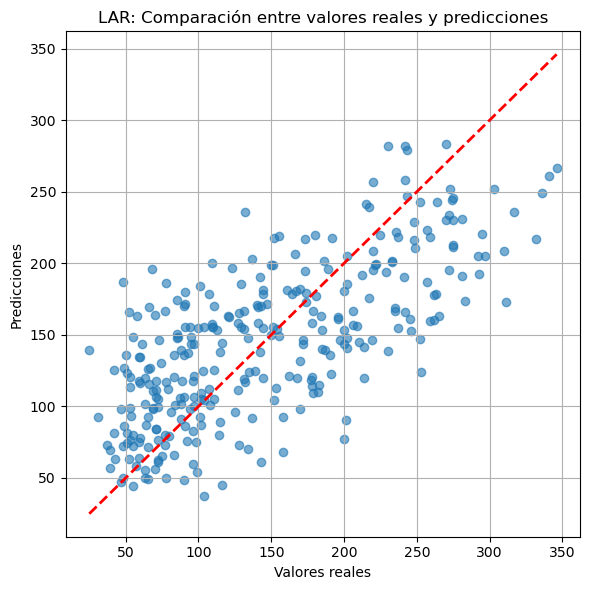

In [ ]:
# Ajustar el modelo LassoLarsCV con validación cruzada
lar_cv = LassoLarsCV(cv=5, max_iter=10000)
lar_cv.fit(X_train, y_train)

# Mostrar el mejor alpha encontrado
print(f"Mejor alpha encontrado: {lar_cv.alpha_}")

# Crear un DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lar_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (LAR):")
print(coef_df.head(10))  # Top 10 características más relevantes

# Hacer predicciones en los datos de entrenamiento
y_pred = lar_cv.predict(X_train)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('LAR: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)  # Diferentes valores de alpha
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con LassoLars
grid_search = GridSearchCV(
    estimator=LassoLars(max_iter=10000),  # Aumentamos max_iter para evitar warnings de convergencia
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto combinado (ya escalado)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame con los resultados de la validación cruzada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de validación (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo LAR
coefficients = best_model.coef_

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Ordenar los coeficientes por su valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo LAR (alpha = {best_model.alpha}):")
print(coef_df)



Coeficientes del mejor modelo LAR (alpha = 1e-06):
  Feature  Coefficient  Abs_Coefficient
4      s1  -727.037516       727.037516
8      s5   703.620308       703.620308
2     bmi   523.336481       523.336481
5      s2   444.997055       444.997055
3      bp   307.061120       307.061120
7      s4   246.174244       246.174244
1     sex  -212.878330       212.878330
6      s3   123.133425       123.133425
9      s6    80.538925        80.538925
0     age   -46.102722        46.102722


In [ ]:
print("\nResultados de la búsqueda con validación cruzada (Lasso LAR):")
results_df


Resultados de la búsqueda con validación cruzada (Lasso LAR):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
0,0.000001,3065.281798,275.394198,2853.301767,56.472591,1
1,0.00001,3065.282166,275.379218,2853.301787,56.472590,2
2,0.0001,3065.288102,275.230465,2853.303762,56.472490,3
3,0.001,3065.573539,273.849302,2853.501300,56.462441,4
4,0.01,3072.108496,262.793845,2861.887051,57.528636,5
5,0.1,3087.693926,222.019372,2910.955768,54.907809,6
6,1.0,3939.542488,583.233307,3791.243594,57.173312,7
7,10.0,5853.579820,1018.696580,5845.395912,254.947897,8
8,100.0,5853.579820,1018.696580,5845.395912,254.947897,8
9,1000.0,5853.579820,1018.696580,5845.395912,254.947897,8


### Incremental Forward Stagewise Regression

In [ ]:
def forward_stagewise_incremental(X, y, epsilon=1e-3, max_iter=1000, tol=1e-6):

    # 1. Estandarizar predictores
    #scaler = StandardScaler()
    #X_std = scaler.fit_transform(X)

    # Inicializar
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)
    r = y.copy()

    for _ in range(max_iter):
        # 2. Correlaciones con el residuo
        correlations = X.T @ r

        # Condición de parada
        max_corr = np.max(np.abs(correlations))
        if max_corr < tol:
            break

        # 3. Identificar el predictor más correlacionado
        j = np.argmax(np.abs(correlations))
        delta = epsilon * np.sign(correlations[j])

        # 4. Actualizar coeficiente y residuo
        beta[j] += delta
        r -= delta * X[:, j]

    return beta

beta_fs = forward_stagewise_incremental(X, y, epsilon=1e-2, max_iter=100000)

# 3. Mostrar resultados
coef_df = pd.DataFrame({
    'Predictores': X.columns,
    'Coeficientes_FSε': beta_fs
}).sort_values(by='Coeficientes_FSε', key=np.abs, ascending=False)

print(coef_df)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_13764\484105970.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta = epsilon * np.sign(correlations[j])


InvalidIndexError: (slice(None, None, None), 2)

### Selector de Dantzig
Aunque no existen implementaciones estándar del Selector de Dantzig en bibliotecas comunes de Python como scikit-learn, es posible resolver este problema utilizando bibliotecas de optimización convexa como cvxpy.

In [ ]:
import cvxpy as cp

# Definir variables
n, p = X_train.shape
beta = cp.Variable(p)
lambda_param = 0.1  # Este valor puede ajustarse según sea necesario

# Definir el problema de optimización
objective = cp.Minimize(cp.norm1(beta))
constraints = [cp.norm_inf(X_train.T @ (y_train - X_train @ beta)) <= lambda_param]
problem = cp.Problem(objective, constraints)

# Resolver el problema
problem.solve()

# Mostrar los coeficientes estimados

# 3. Mostrar resultados
coef_df = pd.DataFrame({
    'Predictores': X.columns,
    'Coeficientes': beta.value
}).sort_values(by='Coeficientes', key=np.abs, ascending=False)

print(coef_df)


IndexError: tuple index out of range

### Grouped LASSO

In [ ]:
# Suponiendo que X_train_scaled y y_train ya están definidos

groups = np.array([0]*4 + [1]*6)

# Inicializar el modelo Group Lasso
model = GroupLasso(
    groups=groups,
    group_reg=0.1,  # Regularización a nivel de grupo
    l1_reg=0.01,    # Regularización L1 individual
    scale_reg='group_size',  # Escalar la regularización según el tamaño del grupo
    subsampling_scheme=1,
    supress_warning=True,
    fit_intercept=True
)

# Ajustar el modelo a los datos
model.fit(X_train, y_train)

# Obtener los coeficientes estimados
coeficientes = model.coef_

# Asegurarse de que los coeficientes sean unidimensionales
coeficientes = coeficientes.flatten()

# Crear un DataFrame para visualizar los coeficientes
coef_df = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': coeficientes
})

# Ordenar por el valor absoluto de los coeficientes
coef_df['Valor absoluto'] = coef_df['Coeficiente'].abs()
coef_df = coef_df.sort_values(by='Valor absoluto', ascending=False)

print(coef_df)


  Característica  Coeficiente  Valor absoluto
8             s5     2.732391        2.732391
2            bmi     2.447235        2.447235
3             bp     2.031396        2.031396
7             s4     1.956187        1.956187
6             s3    -1.886281        1.886281
9             s6     1.732418        1.732418
4             s1     1.042384        1.042384
0            age     0.847187        0.847187
5             s2     0.822437        0.822437
1            sex     0.222775        0.222775


c:\Users\Usuario\Documents\Python Scripts\Lib\site-packages\group_lasso\_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


# Reducción de Dimensión

### Regresión de Componentes Principales

PCA es sensible a la escala de los datos, por lo tanto, es recomendable escalar las características antes de aplicar PCA.

In [ ]:
# Crear el modelo PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Ver la cantidad de varianza explicada por cada componente principal
print("Varianza explicada por componente:", pca.explained_variance_ratio_)

Varianza explicada por componente: [0.40242108 0.14923197]


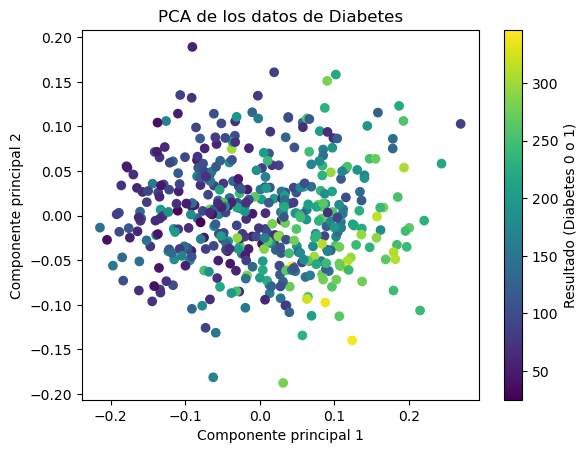

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('PCA de los datos de Diabetes')
plt.colorbar(label='Resultado (Diabetes 0 o 1)')
plt.show()

In [ ]:
# Crear el modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones sobre los datos de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio (MSE): {mse}')

Error cuadrático medio (MSE): 2422.423530492576


In [ ]:
# Crear un pipeline con PCA y regresión lineal
pca = PCA()
model = LinearRegression()

pipeline = Pipeline(steps=[
    ('pca', pca),
    ('regressor', model)
])


In [ ]:
# Definir los parámetros a probar
param_grid = {
    'pca__n_components': list(range(1, X.shape[1] + 1))  # Probar 1 a 10 componentes principales
}

In [ ]:
# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustar el modelo con los datos
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print(f"Mejor número de componentes: {grid_search.best_params_['pca__n_components']}")

# Obtener el modelo final con los mejores parámetros
best_model = grid_search.best_estimator_

Mejor número de componentes: 8


In [ ]:
# Ajustar el mejor modelo con los datos de entrenamiento
best_model.fit(X_train, y_train)

# Realizar predicciones sobre los datos de prueba
y_pred = best_model.predict(X_val)

# Evaluar el modelo
mse = mean_squared_error(y_val, y_pred)
print(f"Error cuadrático medio (MSE) con el mejor número de componentes: {mse}")


Error cuadrático medio (MSE) con el mejor número de componentes: 3533.9157584056197


### PLS

In [ ]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X_train, y_train)

PLSRegression()

In [ ]:
param_grid = {'n_components': range(1, 11)}
grid = GridSearchCV(pls, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=PLSRegression(),
             param_grid={'n_components': range(1, 11)},
             scoring='neg_mean_squared_error')